# <font color='blue'>Part A – Non-Technical :</font>

>___1. Asset Universe:___
>>In this exercise I have chosen to consider only the 50 largest Defi in terms of Market Cap. The market data is collected using coinmarketcap api.

>___2. Asset selection procedure:___
>>I decided to build a portfolio of 10 Defi chosen each time according to the strength of their momentum and the cluster to which they belong.
In order to make a prudent and diversified choice of Defi from my portfolio i used Clustering. Clustering deals with the task of grouping a set of physical or abstract objects into classes such that objects within a class exhibit close similarity to one another, while simultaneously expressing a strong dissimilarity to objects with other classes.
I chose to use the k-means method with a cluster count of 10. So I adjust my portfolio every week (every Thursday precisely. I avoided choosing Friday because it is the last day of the week often very volatile because several Hedge Funds close their positions on Friday) by ordering the Defi according to their momentum and ensuring that they are in different clusters according to an algorithm that I will explain later.

>___3. Choice of algorithm:___
>><font color='red'>__a. Weekly selection:__</font>   
>>><p>After the clustering (taking as input for every asset its mean return and the variance-covariance vector of its    returns with those of other Defi) I got 10 different Defi clusters.
>>><p>A cluster cannot be present more than twice in the portfolio. So every Thursday, I select the 2 best performing Defi in terms of momentum in each cluster. Then I group all the Defi selected in all the clusters and I order them again by momentum and I choose the first ten.
>>><p>The momentum is estimated by calculating the difference between the 60-day and 30-day simple moving average of the logarithm of the price divided by the logarithm of the price: 
***
$$Momentum =  \displaystyle \frac{sma_{60}(y) - sma_{30}(y)}{y}\text{ , where }y = log(price)$$
***
>>><div class="alert alert-block alert-danger"><b>Additional condition:</b> 
    <p>Defi with a momentum > 50 are not selected because I consider it dangerous and it is very likely that the bullish momentum will end very soon.</p>
    <p>If a Defi has experienced a fall of more than 90% in its value it is immediately removed from the global list of Defi and considered as a bankrupt project and no investment in this project will be authorized in the future.</p></div>

>><font color='red'>__b. Constrained Portfolio Optimization:__</font>
>>><p><font color='green'>By investing in this portfolio of Defi i considerthe following objectives:</font>
>>><p>&emsp;(1) maximize expected portfolio return.
>>><p>&emsp;(2) minimize portfolio risk.
$$\displaystyle min \Bigg(\lambda \sum \limits _{i} \sum \limits _{j} W_{i}.W_{j}.\sigma_{ij} - (1-\lambda)\sum W_{i}.\mu_{i}\Bigg)\text{ , where } \lambda \in [0,1] \text{ is the risk aversion parameter}$$
>>><p>&emsp;(3) Exercise caution over the inclusion of all clusters by ensuring that only 30% of the capital is invested  <font color='white'>__</font>in one cluster.
>>><p>&emsp;(4) Having decided on the Defi clusters, ensure that a minimal amount of 5% (at least) of the capital,
<font color='white'>__</font>must be invested in the clusters selected.
$$\displaystyle 0.05 \leq \sum \limits _{i \in C} W_{i} \leq 0.3\text{ , where }C \in Clusters$$
>>><p>&emsp;(5) Some Defi if need be may not be invested in, this means, the lower bounds for the weights could be 0.
$$\displaystyle 0 \leq W_{i} \leq 1\text{ , where }i \in Defi$$
>>><p>&emsp;(6) Ensure a fully invested portfolio, where the entire capital is invested in the Defi of the portfolio.
$$\displaystyle \sum \limits _{i=1} ^{N=10} W_{i} = 1$$
    
>___4. Key metric to use for strategy evaluation:___
>><p><font color='green'>- Sharpe Ratio</font>
>><p><font color='green'>- Skewness</font>
>><p><font color='green'>- Kurtosis</font>
>><p><font color='green'>- Probabilistic Sharpe Ratio</font>

# <font color='blue'>Part B – Technical :</font>

##  <font color='red'>Libraries :</font>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
plt.ioff()
import seaborn as sns
import requests
import json
import cloudscraper
from datetime import datetime,timedelta
from sklearn.cluster import KMeans 
from sklearn.impute import KNNImputer
import itertools
from scipy import optimize 
from functools import reduce
from scipy import stats as scipy_stats


today_date = datetime(2022,10,15,0,0)
#today_date = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)

##  <font color='red'>Data Scraping :</font>

<div class="alert alert-block alert-info">
Getting The 50 largest Defi in terms of Market Cap
</div>

In [2]:
# The web site used : crypto.com

scraper = cloudscraper.create_scraper(
    browser={
        'browser': 'firefox',
        'platform': 'windows',
        'mobile': False
    }
)

defi_list_req = scraper.get('https://price-api.crypto.com/price/v1/tokens',
                 params = {
                     "page":1,
                     "limit":50,
                     "tags":"defi"
                 }   
                )
defi_list = json.loads(defi_list_req.content.decode())
defi_list = [[d['id'],d['name'],d['symbol']] for d in defi_list['data']]

In [3]:
defi_list[:5]

[[4943, 'Dai', 'DAI'],
 [3717, 'Wrapped Bitcoin', 'WBTC'],
 [5805, 'Avalanche', 'AVAX'],
 [7083, 'Uniswap', 'UNI'],
 [1975, 'Chainlink', 'LINK']]

<div class="alert alert-block alert-info">
<p>Getting Market data of all Defi selected
<p>We only keep Defi that started before 2021
</div>

In [4]:
# The web site used : coinmarketcap.com

data_history = {} 
for id_,name,symbol in defi_list:
    defi_req = requests.get("https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart",
                     params = {
                         "id":f"{id_}",
                         "range":"ALL"
                     }
                    ) 

    defi_data = json.loads(defi_req.content.decode())
    prices = {datetime.fromtimestamp(int(item[0])).strftime("%d/%m/%Y") : item[1]['v'][0] for item in defi_data['data']['points'].items()}
    if int(list(prices.keys())[0][-4:])<2021:
        data_history[name] = prices

<p><strong><em>Looking for the youngest project in the list.
<p><strong><em>Our starting date will be the date of the youngest project.

In [5]:
defi_start_date = {item[0]:list(item[1].keys())[0] for item in data_history.items()}
max_minDates = max([(datetime.strptime(t[1], '%d/%m/%Y'),t[0]) for t in defi_start_date.items()])
delta_time = (today_date-max_minDates[0]).days
print(f'The number of Defi : {len(data_history)}')
print(f'- The youngest project is "{max_minDates[1]}" : {max_minDates[0].strftime("%d/%m/%Y")}')
print(f'- The number of days that will be stadied : {delta_time} days')      

The number of Defi : 42
- The youngest project is "Reef" : 29/12/2020
- The number of days that will be stadied : 655 days


## <font color='red'>Data Preparation: </font>

<div class="alert alert-block alert-info">
Creating the price dataframe :
</div>

In [6]:
# List of Dates
dates = [(max_minDates[0]+timedelta(days=i)).strftime("%d/%m/%Y") for i in range(delta_time+1)] 

In [7]:
df = pd.DataFrame({defi:[data_history[defi][d] if d in data_history[defi].keys() else np.nan for d in dates] for defi in data_history.keys()})

___To solve the problem of missing data I used a knn imputer with a neighborhood of 3___

In [8]:
imputer = KNNImputer(n_neighbors=3)
df= pd.DataFrame(imputer.fit_transform(df),columns=df.columns,index=dates)
print('The Final Dataset : ')
df.head()

The Final Dataset : 


,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,Secret,UMA,Injective,Reef,Ren,Request
29/12/2020,1.002900,29431.513989,2.947437,3.727547,12.233673,0.653082,1.011288,2.119271,81.866601,657.211815,...,0.345332,1.015460,2.618241,0.673067,0.621213,7.965536,4.751879,0.027918,0.335007,0.029402
30/12/2020,1.003244,27180.790621,2.925294,3.670331,11.767861,0.648026,1.015077,2.302989,77.906158,564.503654,...,0.726393,1.078194,2.510549,0.580012,0.628436,7.994772,4.311999,0.023483,0.185610,0.033648
31/12/2020,1.003347,29365.144870,2.922048,4.137221,9.427565,0.668939,1.002194,1.989491,80.855245,819.743783,...,0.359617,1.034413,2.597565,0.677185,0.647885,7.861625,3.871555,0.011383,0.324443,0.052669
01/01/2021,1.000167,28963.726548,19.499516,5.216110,11.266762,0.000174,0.995344,1.829956,87.543306,828.629361,...,0.371642,1.039962,2.863348,0.743914,0.614641,7.639793,4.065262,0.013707,0.198038,0.111041
02/01/2021,1.004501,25055.049534,3.662164,4.734603,9.696829,0.649375,1.011849,1.832639,90.384828,582.279519,...,0.374996,1.154681,3.330878,0.575958,0.632922,7.926068,4.079060,0.012195,0.317039,0.028522


<div class="alert alert-block alert-info">
Defi returns computing :
</div>

In [9]:
#store defi prices as an array
arDefiPrices = np.asarray(df)
[rows, cols]= arDefiPrices.shape

In [10]:
#function for Defi Returns computing 
def DefiReturnsComputing(DefiPrice, Rows, Columns):
    
    import numpy as np
    
    DefiReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):  # j: Assets
        for i in range(Rows-1):     #i: Daily Prices
            DefiReturn[i,j]=((DefiPrice[i+1, j]-DefiPrice[i,j])/DefiPrice[i,j])

    return DefiReturn

In [11]:
#compute daily returns of all defies in the mini universe
arReturns = DefiReturnsComputing(arDefiPrices, rows, cols)
print('Size of the array of daily returns of defies:\n', arReturns.shape)
print('Array of daily returns of defies\n',  arReturns)

Size of the array of daily returns of defies:
 (655, 42)
Array of daily returns of defies
 [[ 3.43367709e-04 -7.64732446e-02 -7.51261920e-03 ... -1.58866550e-01
  -4.45951871e-01  1.44421935e-01]
 [ 1.02856339e-04  8.03638967e-02 -1.10968683e-03 ... -5.15255679e-01
   7.47984051e-01  5.65290640e-01]
 [-3.16962686e-03 -1.36698907e-02  5.67323698e+00 ...  2.04186550e-01
  -3.89606362e-01  1.10827794e+00]
 ...
 [-4.45184150e-04 -2.98942279e-02  6.85886431e-04 ... -2.40958741e-02
   5.82028697e-02  3.61250311e-02]
 [ 3.85349392e-04  3.08154315e-02 -1.82591859e-02 ...  5.54987296e-02
  -5.82697097e-02 -6.56517211e-02]
 [ 4.95924203e-04 -2.84739143e-02  7.25976589e-04 ...  5.40688721e-02
   1.15379921e-01  7.02647210e-02]]


In [12]:
# Create Defi returns dataframe
df_returns = pd.DataFrame(arReturns,index=df.index[1:],columns=df.columns)
df_returns.head()

,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,Secret,UMA,Injective,Reef,Ren,Request
30/12/2020,0.000343,-0.076473,-0.007513,-0.015349,-0.038076,-0.007742,0.003746,0.086690,-0.048377,-0.141063,...,1.103462,0.061779,-0.041131,-0.138255,0.011628,0.003670,-0.092570,-0.158867,-0.445952,0.144422
31/12/2020,0.000103,0.080364,-0.001110,0.127207,-0.198872,0.032271,-0.012692,-0.136127,0.037854,0.452150,...,-0.504928,-0.040606,0.034660,0.167537,0.030949,-0.016654,-0.102144,-0.515256,0.747984,0.565291
01/01/2021,-0.003170,-0.013670,5.673237,0.260776,0.195087,-0.999741,-0.006835,-0.080189,0.082716,0.010839,...,0.033439,0.005365,0.102320,0.098538,-0.051313,-0.028217,0.050033,0.204187,-0.389606,1.108278
02/01/2021,0.004333,-0.134951,-0.812192,-0.092312,-0.139342,3741.503071,0.016582,0.001466,0.032458,-0.297298,...,0.009024,0.110311,0.163281,-0.225774,0.029743,0.037472,0.003394,-0.110305,0.600897,-0.743138
03/01/2021,-0.003531,0.283175,-0.045840,0.023667,-0.297370,-0.999646,-0.001300,0.090895,-0.051688,1.445461,...,0.903739,-0.084026,-0.040175,0.294828,-0.045700,0.042389,-0.116824,-0.072431,-0.189616,3.987874


## <font color='red'>Equal Weight Defi Index : 

_I will use this index at the end of this study to build a second strategy identical to the one explained a little above with the only condition of not investing and selling everything when this index is below its 60-day simple moving average and reinvesting when the index goes above this moving average._

In [13]:
equal_weight_index = {}
weight = 1/df_returns.shape[1]
for day in df_returns.index:
    day_index = list(df_returns.index).index(day)
    index_value = 0
    for defi in df_returns.columns:
        index_value+=weight*reduce(lambda x, y: x*y, (1+df_returns.iloc[:day_index+1])[defi])
    equal_weight_index[day] = index_value
        
equal_weight_index = pd.DataFrame({'indexDefi':equal_weight_index.values()},index=equal_weight_index.keys())

In [14]:
# Condition to buy : index above 60 sma
rolling_window = 60
sma60 = equal_weight_index.copy('deep')
for defi in sma60.columns:
    sma60[defi] = equal_weight_index[defi].rolling(rolling_window).mean()
sma60.dropna(inplace=True)
sma60 = pd.concat([equal_weight_index[:rolling_window-1]*0,sma60])

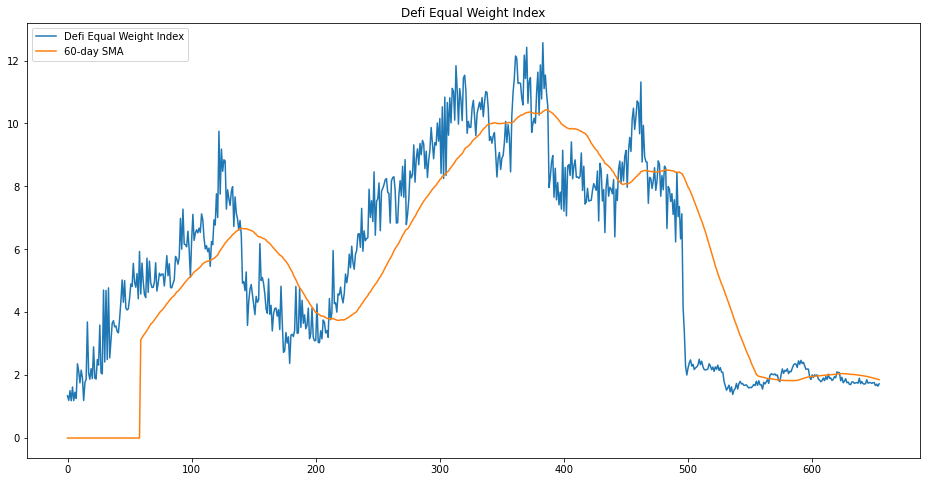

In [15]:
plt.plot(equal_weight_index.indexDefi.values,label="Defi Equal Weight Index")
plt.plot(sma60.indexDefi.values,label="60-day SMA")
plt.legend(loc="upper left")
plt.title('Defi Equal Weight Index')
plt.show()

## <font color='red'>Defi Clustering: 

#### Step 1: Compute mean returns and variance-covariance matrix of returns

meanReturns and covReturns store the outputs of the respective computations.

In [16]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
print('Mean returns:\n', meanReturns)
covReturns = np.cov(arReturns, rowvar=False)
#set precision for printing results
np.set_printoptions(precision=5, suppress = True)
print('Size of Variance-Covariance matrix of returns:\n', covReturns.shape)
print('Variance-Covariance matrix of returns:\n', covReturns)

Mean returns:
 [-3.35086920e-06  1.00327353e-02  4.14034278e-02  4.26740584e-03
  1.54365432e-02  1.04966050e+01  6.49639114e-06  2.34478694e-02
  3.52853315e-03  2.26793080e-02  7.42366285e-05  1.95761517e-02
  7.17955848e-04  4.09522131e-02  3.97909958e-01  4.58345940e-02
  7.98769044e-03  5.85206906e-02  5.52743582e-03  1.38208636e-02
  1.67257475e-03  1.23167189e-01  4.39781377e-03  3.76080027e-02
  1.99682712e-03  3.59141029e-03  3.55824838e-03  1.20575751e-01
  2.34677593e-02  1.49118564e-02  1.25636658e-01  6.81218095e-03
  4.01959419e-02  6.11827992e-03  5.35592761e-03  1.29497543e-02
  9.23877457e-03  1.11292265e-02  2.27720936e-03  8.85659179e-04
  3.49048788e-02  1.69649141e-01]
Size of Variance-Covariance matrix of returns:
 (42, 42)
Variance-Covariance matrix of returns:
 [[ 0.      -0.      -0.00001 ...  0.00001  0.00004 -0.00006]
 [-0.       0.02254  0.00641 ...  0.00164 -0.0024   0.01972]
 [-0.00001  0.00641  0.17177 ...  0.00553  0.00997  0.03066]
 ...
 [ 0.00001  0.00

#### Step 2: Prepare parameters for k-means clustering

Every Defi Ai  is characterized by its mean return and the variance-covariance vector of its returns with those of other assets  Aj . For i = j, it would indicate its own variance of returns. Thus the characteristic vector for asset  Ai  is given by  [μi,σi1,σi2,...σii,...σiN)] , where  μi  indicates the mean return of asset  Ai  and  σi1,σi2,...σii,...σiN  are the variance and covariance of its returns with other assets. It can be seen that  [σi1,σi2,...σii,...σiN]  is nothing but row  i  of the variance-covariance matrix  V  of  N  assets in the stock universe.  σii  which is the variance of the asset return, is the diagonal element of matrix  V  in row i.

The following Python code shows the gathering of parameters for each of the 43 assets in the Defi universe. The parameters are to be provided as inputs to the k-means clustering method.

In [17]:
#prepare asset parameters for k-means clustering
#reshape for concatenation
meanReturns = meanReturns.reshape(len(meanReturns),1)
assetParameters = np.concatenate([meanReturns, covReturns], axis = 1)
print('Size of the asset parameters for clustering:\n', assetParameters.shape)
print('Asset parameters for clustering:\n', assetParameters)

Size of the asset parameters for clustering:
 (42, 43)
Asset parameters for clustering:
 [[-0.       0.      -0.      ...  0.00001  0.00004 -0.00006]
 [ 0.01003 -0.       0.02254 ...  0.00164 -0.0024   0.01972]
 [ 0.0414  -0.00001  0.00641 ...  0.00553  0.00997  0.03066]
 ...
 [ 0.00089  0.00001  0.00164 ...  0.00614  0.0009   0.0083 ]
 [ 0.0349   0.00004 -0.0024  ...  0.0009   0.08106 -0.01276]
 [ 0.16965 -0.00006  0.01972 ...  0.0083  -0.01276  0.93714]]


#### Step 3: Group the assets into clusters using k-means clustering where k =10, which is the portfolio size.

The Python code shows the invocation of the function KMeans from the scikit-learn library.

In [18]:
#kmeans clustering of assets using the characteristic vector of 
#mean return and variance-covariance vector of returns

clusters = 10

assetsCluster= KMeans(algorithm='auto',  max_iter=600, n_clusters=clusters, random_state=2)
print('Clustering of assets completed!') 
assetsCluster.fit(assetParameters)
centroids = assetsCluster.cluster_centers_
labels = assetsCluster.labels_

print('Centroids:\n', centroids)
print('Labels:\n', labels)

Clustering of assets completed!
Centroids:
 [[    0.39791    -0.00031    -0.00421     0.22009     0.02889     0.07133
    -11.57069     0.00117     0.06799     0.01871     0.07093     0.0004
      0.07303     0.00767     0.15536     5.97128     0.17494     0.01918
      0.02253     0.05393     0.05461     0.0242      0.05309     0.01835
      0.15342     0.00745     0.01089     0.00377     0.19601    -0.03031
      0.03005     0.08987     0.05694     0.15197     0.0093      0.02961
      0.05911    -0.00824    -0.01227     0.01657     0.0024     -0.02233
      0.05083]
 [   10.4966      0.02278    -1.20433    -4.90363     0.03209     3.46098
  33934.54528     0.0298      0.07387     1.02677     0.7114     -0.07768
     -3.22923    -0.22648    -4.36191   -11.57069    -4.30905     0.30573
      8.40457     3.9112      0.57858    -0.60458    -7.05989    -1.48476
      3.32728     0.24552     0.31548     0.0707     10.7425     -0.01423
     -0.82231    38.89298     0.31115    -1.66863     

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


#### Step 4: Fix asset labels to points in each cluster

In [19]:
#fixing asset labels to cluster points

assetLabels = df.columns

clusters_dict = {}

print('Defi in each of the clusters:\n',)
assets = np.array(assetLabels)
for i in range(clusters):
    print('Cluster', i+1)
    clt  = np.where(labels == i)
    assetsCluster = assets[clt]
    print(assetsCluster)
    clusters_dict[i] = assetsCluster

Defi in each of the clusters:

Cluster 1
['Fantom']
Cluster 2
['Luna Classic']
Cluster 3
['Dai' 'Uniswap' 'Frax' 'Tezos' 'Aave' 'Maker' 'Neutrino USD' 'The Graph'
 'Curve DAO Token' 'Kava' 'yearn.finance' 'NXM' 'Oasis Network'
 'Reserve Rights' 'Balancer' 'Serum' 'SushiSwap' 'Secret' 'Injective']
Cluster 4
['Rocket Pool']
Cluster 5
['Basic Attention Token']
Cluster 6
['Avalanche' 'PancakeSwap' 'Synthetix' 'THORChain']
Cluster 7
['Chainlink' 'Compound' 'Gnosis' 'Ren']
Cluster 8
['Loopring' 'Request']
Cluster 9
['Wrapped Bitcoin' '1inch Network' 'DeFiChain' 'JUST' '0x' 'SXP' 'UMA'
 'Reef']
Cluster 10
['Ankr']


# <font color='red'>Momentum Calculation
***
$$Momentum =  \displaystyle \frac{sma_{60}(y) - sma_{30}(y)}{y}\text{ , where }y = log(price)$$
***

In [20]:
def smaCrossMomentum(closes,slow_window=60,fast_window=30):
    returns = np.log(closes)
    slow_sma = returns.rolling(slow_window).mean()
    fast_sma = returns.rolling(fast_window).mean()
    return(((fast_sma-slow_sma)*100/returns).values)

In [21]:
momentums = df.copy(deep=True)
for defi in momentums.columns :
        momentums[defi] = smaCrossMomentum(df[defi])

In [22]:
momentums.dropna(inplace=True)
momentums.head()

,Dai,Wrapped Bitcoin,Avalanche,Uniswap,Chainlink,Luna Classic,Frax,Tezos,Aave,Maker,...,0x,Serum,SushiSwap,SXP,Secret,UMA,Injective,Reef,Ren,Request
26/02/2021,-10.151045,1.344057,18.186891,17.851777,10.495098,38.362851,10.587905,18.591436,9.261984,4.298462,...,86.132088,23.926466,19.965353,54.141455,34.053367,13.551696,15.941288,-12.012452,-250.404013,-10.352726
27/02/2021,-3.515546,1.405236,18.298571,17.431916,10.492768,57.213665,45.274801,16.173100,8.971267,4.019519,...,125.048099,25.559546,19.368064,59.671398,35.721370,13.821790,16.021963,-12.334536,2540.526621,-14.565908
28/02/2021,1.268908,1.415463,17.360611,16.887389,9.876241,57.633887,-557.863284,12.233791,8.634475,3.981261,...,132.598797,26.604544,18.606395,53.584096,37.666683,13.272183,15.821229,-12.817036,602.726107,-7.330403
01/03/2021,7.402540,1.435226,17.442430,16.666025,9.610789,30.622532,-86.102200,15.337906,8.278821,3.510528,...,125.970009,30.662094,18.688866,59.810871,41.687181,13.823892,15.705622,-12.410344,-192.509856,-10.785700
02/03/2021,8.460852,1.417146,17.374051,15.418787,8.722485,44.576904,-77.700455,14.147359,7.825130,3.246219,...,141.914083,26.016994,16.878954,40.642395,35.499275,13.680198,14.743647,-12.900415,268.884191,-8.272636


<div class="alert alert-block alert-info">
In this part I will find for each week (Thursday precisely) the list of the 10 most efficient Defi in terms of momentum while respecting the rules described in Part A related to the representativeness of each cluster in the portfolio.
</div>

In [23]:
week_momentum = {}
bankruptcy_defi = {}

# Get 10 defi with highest momentum at the end of each week
for d in momentums.index:
    ind = list(df_returns.index).index(d)
    for defi in df_returns.columns:
        # Check if a Defi fall of more than 90% in its value
        if df_returns[defi].iloc[ind-6:ind+1].min() <= -0.9 and defi not in bankruptcy_defi:
            try : bankruptcy_defi[defi] += [d]
            except: bankruptcy_defi[defi] = [d]
    
    day_name = datetime.strptime(d, "%d/%m/%Y").strftime("%A")
    if day_name == 'Thursday':
        # Defi with a momentum > 50 are not selected
        k = momentums.loc[d][(abs(momentums.loc[d])<50)]
        kk = pd.DataFrame({'momentum':k})
        top_2_cluster = {}
        for i in range(len(clusters_dict)):
            top_2_cluster[i] = sorted([(kk.loc[v].momentum,v,i+1) for v in clusters_dict[i] if (v in kk.index) and (v not in bankruptcy_defi.keys())])[-2:]
        sorted_defi = sorted(list(itertools.chain.from_iterable(top_2_cluster.values())))[::-1][:10]
        sorted_defi = pd.DataFrame({'momentum':[kk.loc[d].momentum for d in [v[1] for v in sorted_defi]],
                                    'cluster' : [v[2] for v in sorted_defi]
                                   },
                                  index=[v[1] for v in sorted_defi])
        week_momentum[d] = sorted_defi

In [24]:
for d in bankruptcy_defi.keys():
    print(f'- The defi "{d}" is considred as a bankrupt project at : {bankruptcy_defi[d][0]}')

- The defi "Luna Classic" is considred as a bankrupt project at : 12/05/2022


In [25]:
# For each week buid a dataframe of the price data of the selected Defi :  
week_data_dict = {w:pd.DataFrame({d:df[d] for d in week_momentum[w].index}).iloc[:list(df.index).index(w)+1] for w in week_momentum.keys()}

#### Example : 
<div class="alert alert-block alert-warning">
<strong><em>Week : 20/05/2021
</div>

In [26]:
print('Defi selected the 20/05/2021')
week_momentum['20/05/2021']

Defi selected the 20/05/2021


,momentum,cluster
The Graph,35.596816,3
Basic Attention Token,18.381262,5
Ren,14.156078,7
Serum,10.718633,3
PancakeSwap,10.025364,6
THORChain,8.509126,6
DeFiChain,5.192348,9
SXP,4.676583,9
Rocket Pool,3.431312,4
Compound,3.243942,7


In [27]:
print('Prices of Defi selected the 20/05/2021')
week_data_dict['20/05/2021']

Prices of Defi selected the 20/05/2021


,The Graph,Basic Attention Token,Ren,Serum,PancakeSwap,THORChain,DeFiChain,SXP,Rocket Pool,Compound
29/12/2020,0.380357,0.207339,0.335007,1.015460,0.536077,1.325331,1.316912,0.673067,2.302271,143.176051
30/12/2020,0.372731,0.205721,0.185610,1.078194,0.564923,1.199241,1.296751,0.580012,2.277459,139.692173
31/12/2020,0.374873,0.568311,0.324443,1.034413,0.601883,1.212944,1.394093,0.677185,12.923895,157.213785
01/01/2021,0.350674,0.199661,0.198038,1.039962,0.623763,2.541288,1.879238,0.743914,2.258948,88.836555
02/01/2021,0.362392,0.627526,0.317039,1.154681,0.661411,1.292074,1.333978,0.575958,12.923895,145.453726
...,...,...,...,...,...,...,...,...,...,...
16/05/2021,1.315126,1.138407,0.773261,6.138949,28.628611,7.204590,3.885548,3.679892,21.456830,586.421686
17/05/2021,1.299053,1.042985,0.911323,9.701702,29.198571,19.467615,3.793552,3.809418,15.861210,684.335243
18/05/2021,1.193968,0.951825,0.718049,9.201895,26.709145,17.863649,3.574875,3.353793,28.146827,694.196132
19/05/2021,1.226397,1.108266,0.909757,9.608845,26.995967,20.341567,3.493042,3.828064,20.618527,667.254452


# <font color='red'>Constrained Portfolio Optimization

In [28]:
from defi.optimization import Optimization

In [29]:
week_optimal_allocation = {
    w:Optimization(week_data_dict[w],week_momentum).getOptimalAllocation() 
    for w in week_data_dict.keys()
}

Asset labels for portfolio : 
 Index(['PancakeSwap', 'Curve DAO Token', 'SXP', 'Secret', 'Luna Classic',
       '1inch Network', 'THORChain', 'Chainlink', 'Compound', 'Rocket Pool'],
      dtype='object')
     fun: -31.536238919024406
     jac: array([  -0.15472,   -0.03462,   -0.04824,   -0.03798, -104.12174,
         -0.02724,   -0.18695,   -0.04136,   -0.03995,   -0.83508])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.10888, 0.02332, 0.0355 , 0.02668, 0.3    , 0.0145 , 0.14112,
       0.0257 , 0.0243 , 0.3    ])
     fun: 22.89077976932591
     jac: array([  -0.30388,   -0.03274,   -0.13348,   -0.05503, 1021.58642,
         -0.05521,   -0.36898,    0.06913,    0.08214,    0.27454])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.07271, 0.3    , 0.17729, 0.05   , 0.     , 0.3    ,
       0.05   , 0.     , 0

     fun: 643.7100456164009
     jac: array([   -3.58442,     0.00572,    -2.00812,    -0.42747, 25786.5036 ,
          -0.67128,    -4.36967,     2.49858,     2.76702,    24.6806 ])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.  , 0.  , 0.3 , 0.25, 0.05, 0.  , 0.3 , 0.05, 0.  , 0.05])
     fun: 671.9291764142484
     jac: array([   -3.73353,     0.00748,    -2.09333,    -0.44439, 26912.18298,
          -0.69927,    -4.55152,     2.60903,     2.88907,    25.78998])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.  , 0.  , 0.3 , 0.25, 0.05, 0.  , 0.3 , 0.05, 0.  , 0.05])
     fun: 700.148307209705
     jac: array([   -3.88266,     0.00922,    -2.17854,    -0.46134, 28037.86233,
          -0.72728,    -4.73339,     2.71945,     3.01109,    26.89935])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit

     fun: 377.9840813722832
     jac: array([   -0.23855,    -2.08704,    -1.20269,     0.36369, 15175.29045,
          -0.38986,    -2.56874,    14.59373,     1.47057,     1.63175])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.25, 0.  , 0.3 , 0.  , 0.05, 0.  , 0.3 , 0.05, 0.05, 0.  ])
     fun: 403.5041389238748
     jac: array([   -0.25225,    -2.2168 ,    -1.27959,     0.39024, 16193.24498,
          -0.41422,    -2.72836,    15.61749,     1.57115,     1.74296])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.25, 0.  , 0.3 , 0.  , 0.05, 0.  , 0.3 , 0.05, 0.05, 0.  ])
     fun: 429.02419647574806
     jac: array([   -0.26595,    -2.34658,    -1.35649,     0.4168 , 17211.1995 ,
          -0.43857,    -2.88798,    16.64125,     1.67173,     1.85416])
 message: 'Optimization terminated successfully'
    nfev: 36
     n

     fun: 275.1192218515465
     jac: array([   -0.70173,    -1.49102,    -0.17387, 11063.03864,    -0.88061,
           0.27854,    -1.8642 ,    10.70539,     1.07425,     1.19549])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.  , 0.25, 0.05, 0.3 , 0.  , 0.3 , 0.05, 0.05, 0.  ])
     fun: 298.4118622345057
     jac: array([   -0.75423,    -1.6048 ,    -0.18574, 11992.09919,    -0.94998,
           0.3042 ,    -2.00594,    11.65588,     1.16672,     1.29782])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.  , 0.25, 0.05, 0.3 , 0.  , 0.3 , 0.05, 0.05, 0.  ])
     fun: 321.7045026175984
     jac: array([   -0.80674,    -1.71859,    -0.19762, 12921.15973,    -1.01935,
           0.32986,    -2.14768,    12.60636,     1.25916,     1.40015])
 message: 'Optimization terminated successfully'
    nfev: 47
     ni

     fun: 102.83236643385037
     jac: array([   0.00294,   -0.07531,   -0.34938,   -0.29867,   -0.61984,
       4188.83662,   -0.97717,   -0.78596,    3.78272,    0.44686])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.  , 0.05, 0.2 , 0.  , 0.  , 0.05, 0.3 , 0.3 , 0.05, 0.05])
     fun: 124.21147209317272
     jac: array([   0.00353,   -0.08511,   -0.41109,   -0.34517,   -0.72036,
       5042.35532,   -1.14835,   -0.91268,    4.66883,    0.54171])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.  , 0.05, 0.2 , 0.  , 0.  , 0.05, 0.3 , 0.3 , 0.05, 0.05])
     fun: 145.59057775248309
     jac: array([   0.00412,   -0.0949 ,   -0.47279,   -0.39165,   -0.82088,
       5895.87401,   -1.31954,   -1.0394 ,    5.55494,    0.63657])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 

     fun: -22.069166479335976
     jac: array([ -0.06247,  -0.02224,  -0.00001, -72.8312 ,  -0.04539,  -0.11325,
        -0.6009 ,  -0.12875,  -0.14428,  -0.06468])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.05   , 0.03612, 0.01388, 0.3    , 0.01535, 0.06782, 0.3    ,
       0.08332, 0.09885, 0.03465])
     fun: 16.023306182217723
     jac: array([  0.04117,  -0.03211,   0.00053, 717.26059,  -0.10358,  -0.20533,
         0.22955,  -0.28695,  -0.25927,  -0.10658])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.05   , 0.     , 0.05   , 0.08489, 0.     , 0.05   ,
       0.3    , 0.3    , 0.11511])
     fun: 35.81523038792081
     jac: array([   0.14493,   -0.04195,    0.00107, 1507.33145,   -0.16156,
         -0.29712,    1.06019,   -0.44507,   -0.37427,   -0.14891])
 message: 'Optimization terminated success

     fun: 431.62511383889165
     jac: array([    2.22244,    -0.23819,     0.01178, 17308.38955,    -1.31768,
          -2.12784,    17.67632,    -3.60624,    -2.67418,    -1.00277])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05, 0.05, 0.  , 0.05, 0.2 , 0.  , 0.05, 0.3 , 0.3 , 0.  ])
     fun: 451.41565662718466
     jac: array([    2.3263 ,    -0.24801,     0.01233, 18098.44505,    -1.37551,
          -2.2194 ,    18.5071 ,    -3.76432,    -2.78917,    -1.04541])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05, 0.05, 0.  , 0.05, 0.2 , 0.  , 0.05, 0.3 , 0.3 , 0.  ])
     fun: 471.2061994155651
     jac: array([    2.43016,    -0.25784,     0.01286, 18888.50053,    -1.43334,
          -2.31098,    19.33789,    -3.92238,    -2.90417,    -1.08805])
 message: 'Optimization terminated successfully'
    nfev: 36
     

     fun: 420.2043339281584
     jac: array([    0.01149, 16846.24499,    -1.27756,    -1.9963 ,     0.03378,
          17.41636,    -2.54845,    -0.93247,     2.18384,    -3.48696])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.03575, 0.05   , 0.2    , 0.     , 0.01425, 0.05   , 0.3    ,
       0.     , 0.05   , 0.3    ])
     fun: 438.6264714365143
     jac: array([    0.01199, 17581.63308,    -1.33118,    -2.07866,     0.03738,
          18.19752,    -2.65323,    -0.97054,     2.28133,    -3.63303])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.03885, 0.05   , 0.2    , 0.     , 0.01115, 0.05   , 0.3    ,
       0.     , 0.05   , 0.3    ])
     fun: 457.04858064993215
     jac: array([    0.01249, 18317.02075,    -1.38479,    -2.16102,     0.04089,
          18.97863,    -2.75799,    -1.0086 ,     2.37882,    -3.77

     fun: 342.2326752889262
     jac: array([    2.76225,     0.01202,    -1.03751,     0.03883,     1.79688,
       13710.91314,    -0.78831,    -2.0879 ,    -1.68441,    14.23322])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05  , 0.1147, 0.3   , 0.0853, 0.05  , 0.05  , 0.    , 0.3   ,
       0.    , 0.05  ])
     fun: 359.5072786881923
     jac: array([    2.91093,     0.01263,    -1.08717,     0.04203,     1.88935,
       14399.6224 ,    -0.82458,    -2.18554,    -1.76336,    14.9711 ])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.11687, 0.3    , 0.08313, 0.05   , 0.05   , 0.     ,
       0.3    , 0.     , 0.05   ])
     fun: 376.7818685627207
     jac: array([    3.05964,     0.01323,    -1.13683,     0.04522,     1.98182,
       15088.33147,    -0.86088,    -2.28317,    -1.84229,    15.70899])
 mess

       0.     , 0.05   , 0.25554])
     fun: 287.55519004697794
     jac: array([   -0.3909 ,     0.05125,    -0.81564,     1.44633,    -1.46801,
          -1.33692, 11533.85389,     0.09837,    12.02423,    -0.79131])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.05   , 0.24759, 0.05   , 0.3    , 0.     , 0.05   ,
       0.     , 0.05   , 0.25241])
     fun: 303.7269580715954
     jac: array([   -0.4125 ,     0.05527,    -0.85909,     1.53039,    -1.5457 ,
          -1.40637, 12178.43919,     0.1061 ,    12.72032,    -0.83401])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.    , 0.05  , 0.2504, 0.05  , 0.3   , 0.    , 0.05  , 0.    ,
       0.05  , 0.2496])
     fun: 319.8984602680265
     jac: array([   -0.4341 ,     0.05929,    -0.90253,     1.61446,    -1.62339,
          -1.47582, 12823.02496,     0.113

     fun: 195.86895389380723
     jac: array([   0.00684,   -0.45392,   -1.19914,   -0.60506,    0.02001,
          1.01149,   -0.99063, 7869.1722 ,    8.15433,    0.78137])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.13496, 0.     , 0.3    , 0.3    , 0.11504, 0.     , 0.     ,
       0.05   , 0.05   , 0.05   ])
     fun: 211.15692253403537
     jac: array([   0.00736,   -0.48456,   -1.28214,   -0.64836,    0.02332,
          1.09323,   -1.05911, 8478.79794,    8.81738,    0.84345])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.13864, 0.     , 0.3    , 0.3    , 0.11136, 0.     , 0.     ,
       0.05   , 0.05   , 0.05   ])
     fun: 226.4448742403966
     jac: array([   0.00789,   -0.5152 ,   -1.36513,   -0.69165,    0.02662,
          1.17498,   -1.12758, 9088.42351,    9.48042,    0.90553])
 message: 'Optimization

     fun: -0.0688305627711563
     jac: array([-0.00032, -0.00016, -0.01994, -0.04093, -0.02454, -0.01876,
       -0.00769, -0.04429, -0.0182 , -0.00925])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.02559, 0.02441, 0.25616, 0.24451, 0.05549, 0.10079, 0.0153 ,
       0.20423, 0.06879, 0.00473])
     fun: -0.05862294059769578
     jac: array([-0.0003 , -0.00012, -0.02393, -0.04019, -0.0137 , -0.01603,
       -0.00672, -0.01873, -0.01606, -0.00588])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02545, 0.02455, 0.21511, 0.22405, 0.07595, 0.10132, 0.03948,
       0.18253, 0.08052, 0.03104])
     fun: -0.05017165770469916
     jac: array([-0.00029, -0.00012, -0.01845, -0.03239, -0.00691, -0.0133 ,
       -0.00599, -0.01607, -0.01505, -0.00528])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
   

       0.     , 0.22525, 0.     ])
     fun: -0.07214240142507843
     jac: array([-0.01828, -0.01856, -0.03728, -0.05264, -0.01727, -0.01897,
       -0.00791, -0.00779, -0.03775, -0.00866])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.28595, 0.07705, 0.06372, 0.23628, 0.05782, 0.07682, 0.01085,
       0.00534, 0.18616, 0.     ])
     fun: -0.06197945293732691
     jac: array([-0.02738, -0.01654, -0.02505, -0.04888, -0.01521, -0.01573,
       -0.00723, -0.00686, -0.0211 , -0.00606])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.2465 , 0.08044, 0.07567, 0.22433, 0.06628, 0.07882, 0.02747,
       0.02316, 0.16268, 0.01465])
     fun: -0.052703869143743226
     jac: array([-0.02197, -0.01457, -0.01832, -0.04131, -0.01376, -0.01303,
       -0.00639, -0.00614, -0.0187 , -0.00543])
 message: 'Optimization terminated succe

     fun: -0.16141857569066378
     jac: array([-0.00885, -0.11524, -0.0356 , -0.0232 , -0.07035, -0.10167,
       -0.00934, -0.03182, -0.25228, -0.01532])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.3    , 0.05   , 0.05   , 0.02935, 0.22065, 0.     ,
       0.05   , 0.3    , 0.     ])
     fun: -0.1475992421687622
     jac: array([-0.00847, -0.09949, -0.03279, -0.02204, -0.06649, -0.09527,
       -0.00866, -0.03024, -0.20219, -0.01317])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.3    , 0.05   , 0.05   , 0.01725, 0.23275, 0.     ,
       0.05   , 0.3    , 0.     ])
     fun: -0.13350774143802802
     jac: array([-0.00809, -0.08476, -0.03004, -0.02084, -0.06215, -0.08851,
       -0.00798, -0.02857, -0.15239, -0.011  ])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
   

       0.05   , 0.     , 0.3    ])
     fun: -0.2620719195832904
     jac: array([-0.00005, -0.00002, -0.14181, -0.04556, -0.36404, -0.08056,
       -0.11323, -0.10522, -0.0108 , -0.33214])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02503, 0.02497, 0.18355, 0.05   , 0.3    , 0.     , 0.06645,
       0.05   , 0.     , 0.3    ])
     fun: -0.24028664715281994
     jac: array([-0.00011, -0.00005, -0.12831, -0.04282, -0.31628, -0.07835,
       -0.10948, -0.09888, -0.00997, -0.27889])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02508, 0.02492, 0.17217, 0.05   , 0.3    , 0.     , 0.07783,
       0.05   , 0.     , 0.3    ])
     fun: -0.21872313261472653
     jac: array([-0.00017, -0.00007, -0.1155 , -0.04006, -0.26862, -0.07603,
       -0.10527, -0.09269, -0.00913, -0.22592])
 message: 'Optimization terminated success

     fun: -0.0027403695505760356
     jac: array([-0.00017, -0.00017,  0.01358,  0.01475,  0.04573,  0.02008,
        0.02185,  0.01897,  0.00501,  0.06003])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.15018, 0.14982, 0.05846, 0.1459 , 0.05   , 0.07481, 0.1197 ,
       0.05   , 0.15112, 0.05   ])
     fun: 0.0006912045713602169
     jac: array([-0.00017, -0.00018,  0.02038,  0.01717,  0.06515,  0.02514,
        0.02652,  0.02477,  0.00581,  0.07982])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.15016, 0.14984, 0.05728, 0.14418, 0.05   , 0.07679, 0.11593,
       0.05   , 0.15582, 0.05   ])
     fun: 0.004757243154790185
     jac: array([-0.00017, -0.00017,  0.0289 ,  0.018  ,  0.08285,  0.03628,
        0.03583,  0.03565,  0.00643,  0.09912])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4

     fun: -0.04277296951681277
     jac: array([-0.00219, -0.00165, -0.00518, -0.00255, -0.00431,  0.00046,
       -0.00279,  0.00085, -0.00582, -0.00018])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.06842, 0.10919, 0.10038, 0.10062, 0.1381 , 0.05971, 0.07133,
       0.08889, 0.18335, 0.08001])
     fun: -0.035090753824773384
     jac: array([-0.00156,  0.00228, -0.00262,  0.00028, -0.00289,  0.0025 ,
       -0.00197,  0.00449, -0.00009,  0.00638])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.08173, 0.10884, 0.10691, 0.1055 , 0.119  , 0.04903, 0.08419,
       0.09252, 0.17649, 0.07579])
     fun: -0.028295533904832443
     jac: array([-0.00091,  0.00607, -0.00008,  0.00304, -0.00209,  0.00417,
       -0.00113,  0.00809,  0.00539,  0.01309])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5


     fun: -0.1879925340327326
     jac: array([ 0.00012, -0.05729, -0.04499, -0.00007, -0.06643, -0.0317 ,
       -0.02286, -0.03729, -0.12061, -0.00486])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02472, 0.15194, 0.08508, 0.02528, 0.09733, 0.     , 0.05   ,
       0.26565, 0.3    , 0.     ])
     fun: -0.15938789223407276
     jac: array([ 0.0001 , -0.04387, -0.04126, -0.00007, -0.06287, -0.02531,
       -0.02002, -0.01959, -0.08193, -0.00496])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02474, 0.16169, 0.10605, 0.02526, 0.08081, 0.0093 , 0.05672,
       0.23543, 0.3    , 0.     ])
     fun: -0.13443299267400544
     jac: array([ 0.00009, -0.03275, -0.0378 , -0.00006, -0.05538, -0.02018,
       -0.01677, -0.01361, -0.04252, -0.00502])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
   

     fun: -0.2609682737956537
     jac: array([ 0.00015, -0.15163, -0.05186, -0.00446, -0.02648, -0.1416 ,
       -0.17196, -0.00487, -0.01664, -0.13502])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.01822, 0.13413, 0.     , 0.03178, 0.05   , 0.25171, 0.29329,
       0.     , 0.05   , 0.17087])
     fun: -0.22173740061126726
     jac: array([ 0.00012, -0.09018, -0.04489, -0.00409, -0.02401, -0.08597,
       -0.12938, -0.00501, -0.01033, -0.07991])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.01881, 0.11238, 0.     , 0.03119, 0.05   , 0.24324, 0.3    ,
       0.     , 0.05   , 0.19437])
     fun: -0.18574605940505343
     jac: array([ 0.00009, -0.03484, -0.03695, -0.00374, -0.02162, -0.03973,
       -0.08892, -0.00509, -0.00468, -0.02885])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
   

     fun: -0.08969699790839922
     jac: array([ 0.00218, -0.00948, -0.01133, -0.00308, -0.00005, -0.02747,
       -0.0125 , -0.00143, -0.009  , -0.00442])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.01698, 0.16009, 0.06422, 0.05063, 0.02496, 0.18931, 0.15168,
       0.03371, 0.07516, 0.23325])
     fun: -0.073785934480156
     jac: array([ 0.00621, -0.00313, -0.00308,  0.09838, -0.00005, -0.02401,
       -0.00769, -0.0009 , -0.00716, -0.00636])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.03729, 0.14844, 0.06881, 0.05   , 0.05217, 0.16123, 0.13348,
       0.05774, 0.08091, 0.20993])
     fun: -0.03225996723823324
     jac: array([ 0.00554, -0.06219, -0.0375 ,  0.27574, -0.00006, -0.03383,
       -0.16077, -0.0018 , -0.0156 , -0.14666])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 2
    

     fun: -0.1521324770878868
     jac: array([-0.00215, -0.04158,  0.00983, -0.03085, -0.00247, -0.03937,
       -0.01512, -0.00158, -0.08993, -0.01063])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.02548, 0.19953, 0.08263, 0.07054, 0.02452, 0.22946, 0.05144,
       0.     , 0.3    , 0.0164 ])
     fun: -0.12999312031079335
     jac: array([-0.00174, -0.03563, -0.00775, -0.02344, -0.00236, -0.03962,
       -0.01296, -0.00173, -0.05468, -0.01047])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.02366, 0.24533, 0.06797, 0.08197, 0.02634, 0.20472, 0.05   ,
       0.     , 0.3    , 0.     ])
     fun: -0.10930746599743354
     jac: array([-0.00133, -0.03018, -0.01934, -0.0168 , -0.00227, -0.04   ,
       -0.01051, -0.00189, -0.0191 , -0.00952])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 6
   

       0.     , 0.05   , 0.3    ])
     fun: -0.2910203981334242
     jac: array([-0.09287, -0.05445, -0.00006, -0.08173, -0.07424,  0.00017,
       -0.21033, -0.00239, -0.02602, -0.21222])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05805, 0.05   , 0.02516, 0.19195, 0.     , 0.02484, 0.3    ,
       0.     , 0.05   , 0.3    ])
     fun: -0.24616258450738582
     jac: array([-0.07862, -0.05274, -0.00006, -0.06524, -0.06163,  0.00014,
       -0.1799 , -0.00209, -0.02372, -0.14487])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.09745, 0.05347, 0.02516, 0.14908, 0.     , 0.02484, 0.3    ,
       0.     , 0.05   , 0.3    ])
     fun: -0.2091187181104185
     jac: array([-0.06569, -0.05029, -0.00007, -0.08223, -0.04975,  0.00011,
       -0.15059, -0.00179, -0.02153, -0.07805])
 message: 'Optimization terminated successf

       0.05156, 0.3    , 0.3    ])
     fun: -0.17519434131306288
     jac: array([-0.01157, -0.05222, -0.00319, -0.04823, -0.10569, -0.05044,
       -0.00084, -0.02203, -0.11727, -0.01704])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.04287, 0.12571, 0.     , 0.08599, 0.09635, 0.0113 , 0.00713,
       0.05   , 0.3    , 0.28064])
     fun: -0.14903853060105823
     jac: array([-0.00768, -0.03954, -0.00277, -0.04327, -0.04636, -0.04038,
       -0.00103, -0.0205 , -0.08047, -0.0216 ])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.04065, 0.13611, 0.     , 0.10496, 0.08006, 0.02167, 0.00935,
       0.0591 , 0.3    , 0.24809])
     fun: -0.12630034317828193
     jac: array([-0.00597, -0.02893, -0.00227, -0.03917, -0.0387 , -0.03254,
       -0.00109, -0.01729, -0.04656, -0.011  ])
 message: 'Optimization terminated succes

       0.05   , 0.3    , 0.     ])
     fun: -0.2394431634025469
     jac: array([-0.01092, -0.07656, -0.05695, -0.0035 , -0.05771, -0.17184,
       -0.00068, -0.03176, -0.15476, -0.08083])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.04354, 0.09392, 0.05837, 0.     , 0.14771, 0.3    , 0.00646,
       0.05   , 0.3    , 0.     ])
     fun: -0.204360453118897
     jac: array([-0.01065, -0.06455, -0.0539 , -0.00294, -0.0726 , -0.14468,
       -0.0004 , -0.0267 , -0.08893, -0.06848])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.04134, 0.1086 , 0.07533, 0.     , 0.11514, 0.3    , 0.00866,
       0.05093, 0.3    , 0.     ])
     fun: -0.17427134332482486
     jac: array([-0.01081, -0.0532 , -0.05101, -0.00238, -0.10177, -0.11793,
       -0.0001 , -0.02111, -0.02258, -0.05636])
 message: 'Optimization terminated successfu

     fun: 6.643818253092846
     jac: array([ -0.00077,  -0.01805,  -0.0547 ,  -0.00893,  -0.03064,  -0.93573,
        -0.21431, 315.48226,  -0.01495,  -0.52487])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.01337, 0.05129, 0.12388, 0.03663, 0.12483, 0.3    , 0.     ,
       0.05   , 0.     , 0.3    ])
     fun: 15.385269212818029
     jac: array([ -0.00149,   0.02607,  -0.06025,  -0.0111 ,   0.0552 ,  -0.74231,
        -0.2753 , 662.77672,  -0.02685,  -0.58582])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.  , 0.05, 0.2 , 0.05, 0.05, 0.3 , 0.  , 0.05, 0.  , 0.3 ])
     fun: 24.130644827201017
     jac: array([  -0.00222,    0.07056,   -0.06748,   -0.01325,    0.14217,
         -0.55749,   -0.33633, 1010.2453 ,   -0.0387 ,   -0.64581])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 3
    nj

       0.05   , 0.14049, 0.3    ])
     fun: 190.03931281232323
     jac: array([  -0.01612,    0.93021,   -0.26854,   -0.05533,    1.80473,
         -0.0613 ,   -1.5127 , 7621.73904,   -0.26302,   -1.75616])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.05   , 0.15674, 0.07165, 0.05   , 0.17835, 0.     ,
       0.05   , 0.14326, 0.3    ])
     fun: 198.76667445718263
     jac: array([  -0.01685,    0.97565,   -0.28025,   -0.05753,    1.89217,
         -0.06268,   -1.57494, 7969.80812,   -0.27479,   -1.81417])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.05   , 0.15398, 0.07344, 0.05   , 0.17656, 0.     ,
       0.05   , 0.14602, 0.3    ])
     fun: 207.49394547818343
     jac: array([  -0.01758,    1.02109,   -0.29196,   -0.05972,    1.9796 ,
         -0.06418,   -1.63718, 8317.87759,   -0.28656, 

     fun: 141.9002646590675
     jac: array([  -0.01224, 5702.1525 ,    0.69645,    1.33031,   -0.30006,
         -0.04817,   -1.21465,   -0.69702,   -0.1985 ,   -1.27802])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.05, 0.05, 0.05, 0.2 , 0.05, 0.  , 0.3 , 0.  , 0.3 ])
     fun: 150.34961826247851
     jac: array([  -0.01296, 6039.40192,    0.74139,    1.41574,   -0.31461,
         -0.05057,   -1.27599,   -0.73252,   -0.20999,   -1.32654])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.05, 0.05, 0.05, 0.2 , 0.05, 0.  , 0.3 , 0.  , 0.3 ])
     fun: 158.79897186581172
     jac: array([  -0.01368, 6376.65133,    0.78633,    1.50116,   -0.32917,
         -0.05297,   -1.33732,   -0.76803,   -0.22149,   -1.37507])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0

     fun: 80.68632747127391
     jac: array([  -0.00691,    0.37312,   -0.19949,    0.00287, 3248.22823,
         -0.48149,    0.69105,   -0.24708,    3.43143,    0.35902])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12813, 0.     , 0.     , 0.07187, 0.05   , 0.3    , 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 88.91149736491127
     jac: array([  -0.00759,    0.4175 ,   -0.21432,    0.00316, 3576.06402,
         -0.52063,    0.77218,   -0.26846,    3.80465,    0.39657])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12782, 0.     , 0.     , 0.07218, 0.05   , 0.3    , 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 97.1366668928538
     jac: array([  -0.00828,    0.46188,   -0.22915,    0.00344, 3903.89981,
         -0.55976,    0.85332,   -0.28985,    4.17788,    0.43412])
 message: 'Optimization te

     fun: 54.30744847006075
     jac: array([  -0.03146,    0.00194,   -0.17541, 2196.39747,   -0.35217,
          2.24736,   -0.10583,   -0.27373,    0.20638,    0.23963])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.20414, 0.04586, 0.3    , 0.05   , 0.3    , 0.05   , 0.     ,
       0.     , 0.05   , 0.     ])
     fun: 62.282359777093234
     jac: array([  -0.03325,    0.00221,   -0.19594, 2514.34379,   -0.38987,
          2.61006,   -0.11965,   -0.30465,    0.2393 ,    0.27611])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.20445, 0.04555, 0.3    , 0.05   , 0.3    , 0.05   , 0.     ,
       0.     , 0.05   , 0.     ])
     fun: 70.25726774224802
     jac: array([  -0.03505,    0.00249,   -0.21647, 2832.29003,   -0.42757,
          2.97276,   -0.13347,   -0.33557,    0.27222,    0.31259])
 message: 'Optimization 

     fun: -8.626403530360655
     jac: array([ -0.05009,  -0.01864,  -0.03109,  -0.00004, -28.37811,  -0.09828,
        -0.08764,  -0.28444,  -0.02438,  -0.01529])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.0442 , 0.04379, 0.0058 , 0.00621, 0.3    , 0.13576, 0.11424,
       0.3    , 0.03418, 0.01582])
     fun: 6.265740178517189
     jac: array([ -0.06262,  -0.0202 ,  -0.05158,  -0.00068, 280.36135,  -0.13577,
        -0.12614,   0.06816,   0.0076 ,   0.02017])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.18583, 0.18293, 0.11417, 0.06707, 0.05   , 0.18005, 0.11995,
       0.05   , 0.05   , 0.     ])
     fun: 14.011193523038944
     jac: array([ -0.07552,  -0.02195,  -0.07191,  -0.00132, 589.09814,  -0.17376,
        -0.16431,   0.42078,   0.03955,   0.05562])
 message: 'Optimization terminated successfully'
    

     fun: 215.33251570705613
     jac: array([  -0.43234,   -0.06073,   -0.58693,   -0.01799, 8615.59467,
         -1.16027,   -1.16111,    9.59595,    0.86887,    0.97816])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.     , 0.25   , 0.3    , 0.     , 0.05   , 0.15573, 0.14427,
       0.05   , 0.05   , 0.     ])
     fun: 223.07568646697928
     jac: array([  -0.446  ,   -0.06224,   -0.60677,   -0.01863, 8924.30798,
         -1.19839,   -1.19926,    9.94882,    0.90077,    1.01363])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.    , 0.25  , 0.3   , 0.    , 0.05  , 0.1552, 0.1448, 0.05  ,
       0.05  , 0.    ])
Asset labels for portfolio : 
 Index(['Secret', 'Frax', 'SXP', '1inch Network', 'Luna Classic', 'Avalanche',
       'THORChain', 'Rocket Pool', 'Chainlink', 'Compound'],
      dtype='object')
     fun: -8.3

     fun: 171.61568425842643
     jac: array([  -0.03915,    0.00616,   -0.47839,   -0.12866, 6871.77299,
         -0.94896,   -0.95655,    7.63912,    0.69513,    0.77548])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.     , 0.3    , 0.     , 0.05   , 0.26808, 0.03192,
       0.05   , 0.05   , 0.     ])
     fun: 179.13978770252155
     jac: array([  -0.04008,    0.00643,   -0.49774,   -0.13387, 7171.74548,
         -0.98593,   -0.9939 ,    7.98332,    0.72639,    0.80986])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.     , 0.3    , 0.     , 0.05   , 0.26778, 0.03222,
       0.05   , 0.05   , 0.     ])
     fun: 186.66389058834594
     jac: array([  -0.04102,    0.0067 ,   -0.51709,   -0.13907, 7471.71814,
         -1.02295,   -1.03123,    8.32752,    0.75764,    0.84425])
 message: 'Optimizatio

     fun: 130.32095067141327
     jac: array([  -0.03416,   -0.3685 ,    0.03657,   -0.09829,   -0.75041,
       5224.61558,   -0.73785,    5.75991,    0.52528,    0.58933])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.3    , 0.     , 0.     , 0.23651, 0.05   , 0.06349,
       0.05   , 0.05   , 0.     ])
     fun: 137.63873593379523
     jac: array([  -0.03507,   -0.38716,    0.03942,   -0.10329,   -0.78657,
       5516.36167,   -0.77367,    6.09509,    0.55574,    0.62286])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.3    , 0.     , 0.     , 0.23659, 0.05   , 0.06341,
       0.05   , 0.05   , 0.     ])
     fun: 144.95652096044282
     jac: array([  -0.03597,   -0.40583,    0.04227,   -0.10829,   -0.82273,
       5808.10771,   -0.80949,    6.43028,    0.58619,    0.65639])
 message: 'Optimizatio

       0.05   , 0.     , 0.05   ])
     fun: 62.737988693042624
     jac: array([  -0.15848,   -0.02684,   -0.00524,   -0.19608,   -0.41198,
       2529.48806,   -0.40395,    2.67771,    0.24339,    0.20719])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.20929, 0.04071, 0.3    , 0.23615, 0.05   , 0.06385,
       0.05   , 0.     , 0.05   ])
     fun: 69.86058929233528
     jac: array([  -0.17085,   -0.02795,   -0.00582,   -0.21424,   -0.44744,
       2813.44705,   -0.43846,    3.00459,    0.27295,    0.23733])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.20383, 0.04617, 0.3    , 0.23397, 0.05   , 0.06603,
       0.05   , 0.     , 0.05   ])
     fun: 76.98316622578332
     jac: array([  -0.18322,   -0.02906,   -0.0064 ,   -0.23241,   -0.48286,
       3097.40572,   -0.47299,    3.33147,    0.30251,   

     fun: 26.424855361829355
     jac: array([  -0.0229 ,   -0.08737,   -0.00226,   -0.23479, 1081.02541,
         -0.02675,    1.01215,   -0.22095,    0.05015,    0.09428])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.17973, 0.3    , 0.07027, 0.18932, 0.05   , 0.     , 0.05   ,
       0.11068, 0.05   , 0.     ])
     fun: 33.364137157738284
     jac: array([  -0.0237 ,   -0.09747,   -0.00283,   -0.26851, 1357.63105,
         -0.0315 ,    1.33062,   -0.25408,    0.07956,    0.12326])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.18337, 0.3    , 0.06663, 0.19654, 0.05   , 0.     , 0.05   ,
       0.10346, 0.05   , 0.     ])
     fun: 40.30358819972224
     jac: array([  -0.02459,   -0.10759,   -0.00339,   -0.30258, 1634.23944,
         -0.03626,    1.64904,   -0.28711,    0.10888,    0.15223])
 message: 'Optimization

Asset labels for portfolio : 
 Index(['Secret', 'Neutrino USD', 'Avalanche', 'Luna Classic',
       'Basic Attention Token', 'Rocket Pool', 'Gnosis', '1inch Network',
       'THORChain', 'Chainlink'],
      dtype='object')
     fun: -7.535618695450079
     jac: array([ -0.01869,   0.00003,  -0.09525, -24.77012,  -0.10037,  -0.25498,
        -0.06402,  -0.00736,  -0.08622,  -0.02173])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.04415, 0.00585, 0.086  , 0.3    , 0.09648, 0.3    , 0.05   ,
       0.05   , 0.06752, 0.     ])
     fun: 5.469139048601015
     jac: array([ -0.01989,  -0.00053,  -0.12881, 245.27855,  -0.03115,   0.05778,
        -0.03499,  -0.01194,  -0.11855,   0.00623])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.10431, 0.     , 0.18398, 0.05   , 0.22334, 0.05   , 0.2204 ,
       0.05195, 0.11602, 0.  

     fun: 167.92769495563334
     jac: array([  -0.04523,   -0.01373,   -0.92485, 6718.06101,    1.57579,
          7.53217,    0.6485 ,   -0.1194 ,   -0.89597,    0.67885])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15784, 0.04216, 0.23921, 0.05   , 0.05   , 0.05   , 0.05   ,
       0.3    , 0.06079, 0.     ])
     fun: 174.6964250356354
     jac: array([  -0.0462 ,   -0.01427,   -0.9571 , 6987.76875,    1.64279,
          7.84378,    0.67727,   -0.12387,   -0.92871,    0.70691])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15955, 0.04045, 0.24125, 0.05   , 0.05   , 0.05   , 0.05   ,
       0.3    , 0.05875, 0.     ])
     fun: 181.46396896387944
     jac: array([  -0.04148,   -0.01478,   -0.96257, 7257.27779,    1.70866,
          8.15966,    0.71307,   -0.12769,   -0.96959,    0.73567])
 message: 'Optimization

       0.05   , 0.1    , 0.3    ])
     fun: 110.6616967338336
     jac: array([  -0.00932,   -0.03341,    1.04359,   -0.60583,    5.04818,
       4440.1626 ,    1.09154,    0.44417,   -0.15348,   -0.89522])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.00866, 0.04134, 0.05   , 0.3    , 0.05   , 0.05   , 0.05   ,
       0.05   , 0.1    , 0.3    ])
     fun: 117.25250006364114
     jac: array([  -0.00987,   -0.03499,    1.11082,   -0.63602,    5.35977,
       4702.76926,    1.17154,    0.47399,   -0.16227,   -0.92592])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.00811, 0.04189, 0.05   , 0.3    , 0.05   , 0.05   , 0.05   ,
       0.05   , 0.1    , 0.3    ])
     fun: 123.84330252159636
     jac: array([  -0.01042,   -0.03657,    1.17806,   -0.66621,    5.67137,
       4965.37589,    1.25155,    0.50382,   -0.17105,  

     fun: 56.605848948463354
     jac: array([  -0.07998,   -0.00463,   -0.01996,    0.4816 ,    2.44825,
         -0.30754, 2282.85344,    0.51107,    0.22434,   -0.08345])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.19708, 0.     , 0.05   , 0.05   , 0.05   , 0.3    , 0.05   ,
       0.05   , 0.05   , 0.20292])
     fun: 63.05167926496883
     jac: array([  -0.08935,   -0.00515,   -0.02152,    0.54587,    2.7464 ,
         -0.335  , 2539.38031,    0.59451,    0.25387,   -0.0922 ])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.1859, 0.    , 0.05  , 0.05  , 0.05  , 0.3   , 0.05  , 0.05  ,
       0.05  , 0.2141])
     fun: 69.49663784689074
     jac: array([  -0.0982 ,   -0.00567,   -0.02308,    0.61013,    3.04455,
         -0.36244, 2795.90579,    0.67797,    0.28341,   -0.10096])
 message: 'Optimization terminated

       0.05   , 0.05   , 0.05   ])
     fun: 29.997994491870795
     jac: array([  -0.20947,   -0.00253,   -0.03123,   -0.33491,    1.23061,
         -0.20948, 1226.35956,    0.16824,    0.09677,   -0.04878])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.24783, 0.     , 0.05   , 0.3    , 0.05   , 0.15217, 0.05   ,
       0.05   , 0.05   , 0.05   ])
     fun: 36.28525907662819
     jac: array([  -0.2348 ,   -0.00304,   -0.03229,   -0.3717 ,    1.52287,
         -0.23474, 1476.53462,    0.24866,    0.12568,   -0.05736])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.21668, 0.     , 0.05   , 0.3    , 0.05   , 0.18332, 0.05   ,
       0.05   , 0.05   , 0.05   ])
     fun: 42.569133850105665
     jac: array([  -0.25666,   -0.00355,   -0.03338,   -0.40847,    1.81515,
         -0.25998, 1726.70292,    0.32917,    0.15466,  

       0.22038, 0.05   , 0.05   ])
     fun: 10.851746897657852
     jac: array([ -0.01009,  -0.49889,  -0.02768,  -0.21895,   0.34389,  -0.01687,
       465.67471,  -0.07977,   0.00156,  -0.13402])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.3 , 0.05, 0.3 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 ])
     fun: 17.006302767285778
     jac: array([ -0.0116 ,  -0.3297 ,  -0.02972,  -0.2538 ,   0.63138,  -0.02037,
       709.68063,   0.00364,   0.03345,  -0.15661])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.  , 0.3 , 0.05, 0.3 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 ])
     fun: 23.160858636911836
     jac: array([ -0.01314,  -0.22451,  -0.03156,  -0.28901,   0.91848,  -0.02408,
       953.85876,   0.08651,   0.06405,  -0.18028])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  sta

     fun: -6.889825567645707
     jac: array([ -0.00003,  -0.82177,  -0.14986,  -0.02313,  -0.00879,  -0.07947,
        -0.22726, -21.97579,  -0.0613 ,  -0.01955])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.00185, 0.3    , 0.05   , 0.04815, 0.01421, 0.05   , 0.15   ,
       0.3    , 0.05   , 0.03579])
     fun: 4.592591603568529
     jac: array([  0.00022,  -0.65553,  -0.18396,  -0.02518,  -0.01218,  -0.10056,
         0.05363, 216.49997,  -0.03064,  -0.02788])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.     , 0.3    , 0.3    , 0.05   , 0.00348, 0.15   , 0.05   ,
       0.05   , 0.05   , 0.04652])
     fun: 10.604001519316938
     jac: array([  0.00048,  -0.48926,  -0.21807,  -0.02724,  -0.01557,  -0.12165,
         0.33452, 454.97658,   0.00003,  -0.03623])
 message: 'Optimization terminated successfully'
    

       0.05   , 0.05   , 0.07115])
     fun: 124.52083324291291
     jac: array([   0.00479,   -0.22877,   -0.88322,   -0.05578,   -0.0895 ,
         -0.5676 ,    5.63891, 4992.03254,    0.51172,   -0.18855])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.     , 0.12668, 0.3    , 0.05   , 0.     , 0.3    , 0.05   ,
       0.05   , 0.05   , 0.07332])
     fun: 130.51180686188795
     jac: array([   0.00501,   -0.23605,   -0.91832,   -0.05724,   -0.09347,
         -0.59184,    5.91796, 5230.8844 ,    0.53815,   -0.19644])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.    , 0.1247, 0.3   , 0.05  , 0.    , 0.3   , 0.05  , 0.05  ,
       0.05  , 0.0753])
     fun: 136.50270724404078
     jac: array([   0.00523,   -0.24343,   -0.95342,   -0.05869,   -0.09743,
         -0.61609,    6.19702, 5469.73653,    0.56457,   -0.20433

       0.08945, 0.06763, 0.10976])
     fun: 0.003748794249210076
     jac: array([0.00284, 0.60838, 0.00011, 0.0228 , 0.00406, 0.01436, 0.02277,
       0.02143, 0.00401, 0.01022])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.15348, 0.05   , 0.14652, 0.07556, 0.13665, 0.06794, 0.1103 ,
       0.08621, 0.05783, 0.11551])
     fun: 0.00835857078037558
     jac: array([0.00376, 0.68078, 0.00012, 0.02586, 0.00475, 0.01767, 0.02683,
       0.02518, 0.00986, 0.01197])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.15139, 0.05   , 0.14861, 0.07665, 0.14701, 0.06089, 0.10475,
       0.08492, 0.05296, 0.12282])
     fun: 0.012751119357180866
     jac: array([0.00465, 0.7523 , 0.00014, 0.02879, 0.00546, 0.02087, 0.03047,
       0.02884, 0.0176 , 0.01376])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 

     fun: 73.45877401706412
     jac: array([  -0.10032,   -0.04095,   -0.03815,   -0.05407,    0.01669,
          0.34383,   -0.35287,    0.28905, 2951.62816,    3.24578])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.3    , 0.09329, 0.15671, 0.     , 0.     , 0.     , 0.3    ,
       0.05   , 0.05   , 0.05   ])
     fun: 79.2035954682899
     jac: array([  -0.10647,   -0.04205,   -0.03992,   -0.0578 ,    0.01907,
          0.37506,   -0.37573,    0.31451, 3180.44944,    3.5122 ])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.3   , 0.0987, 0.1513, 0.    , 0.    , 0.    , 0.3   , 0.05  ,
       0.05  , 0.05  ])
     fun: 84.9481450543667
     jac: array([  -0.11261,   -0.04315,   -0.04152,   -0.06154,    0.02144,
          0.40629,   -0.39859,    0.33998, 3409.2703 ,    3.77862])
 message: 'Optimization terminated su

       0.11848, 0.3    , 0.08958])
     fun: -0.07967769943172195
     jac: array([-0.01186, -0.00003, -0.03128, -0.01889, -0.00184, -0.00126,
       -0.03191, -0.01738, -0.03458, -0.01439])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.05109, 0.     , 0.15352, 0.08965, 0.02646, 0.02354, 0.15578,
       0.11469, 0.3    , 0.08528])
     fun: -0.06703703468657213
     jac: array([-0.00997, -0.00004, -0.0253 , -0.05355, -0.00144, -0.00094,
       -0.02733, -0.01307, -0.01021, -0.01207])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.06026, 0.00065, 0.16105, 0.07087, 0.0265 , 0.0235 , 0.16351,
       0.10914, 0.29811, 0.0864 ])
     fun: -0.05630303959037769
     jac: array([-0.0082 , -0.00003, -0.02119, -0.0653 , -0.00114, -0.00062,
       -0.02243, -0.00769, -0.00744, -0.00963])
 message: 'Optimization terminated succes

     fun: -0.05509864858788594
     jac: array([-0.02367, -0.00074, -0.00542, -0.00805, -0.01147, -0.00739,
       -0.00779, -0.02505, -0.00585, -0.00873])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15461, 0.02158, 0.04692, 0.06318, 0.05888, 0.06324, 0.09902,
       0.15739, 0.24915, 0.08602])
     fun: -0.04642312004891648
     jac: array([-0.02016, -0.00026, -0.00455, -0.00641, -0.00668, -0.00566,
       -0.00228, -0.02136,  0.00452, -0.00572])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15583, 0.03656, 0.05986, 0.0734 , 0.05   , 0.07292, 0.0933 ,
       0.1577 , 0.21121, 0.08922])
     fun: -0.03923943261327698
     jac: array([-0.01541, -0.00002, -0.00405, -0.00506,  0.0201 , -0.00463,
        0.00123, -0.01304, -0.01198, -0.00508])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
  

       0.05   , 0.05   , 0.14096])
     fun: 9.763451619177621
     jac: array([  0.01171,   0.00739,  -0.02564,  -0.01037,  -0.1268 ,   0.00035,
        -0.03064, 410.63866,   0.2913 ,  -0.01041])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.03182, 0.13444, 0.07888, 0.3    , 0.0246 , 0.16556,
       0.05   , 0.05   , 0.1147 ])
     fun: 15.164717935813748
     jac: array([  0.0663 ,   0.03774,  -0.03459,  -0.00797,  -0.15101,   0.00054,
        -0.0351 , 625.76801,   0.543  ,   0.01294])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.05   , 0.017  , 0.14405, 0.09114, 0.3    , 0.06132, 0.15595,
       0.05   , 0.05   , 0.08054])
     fun: 20.563541193747525
     jac: array([  0.12106,   0.06784,  -0.04354,  -0.00553,  -0.17547,   0.00072,
        -0.03956, 840.862  ,   0.79453,   0.03593])
 message: 'Optimiz

     fun: 123.14521437837278
     jac: array([   1.15474,    0.64188,   -0.21249,    0.03613,   -0.63104,
          0.00425,   -0.13458, 4928.44133,    5.57176,    0.48726])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.     , 0.3    , 0.02714, 0.3    , 0.17286, 0.     ,
       0.05   , 0.05   , 0.05   ])
     fun: 128.5441696985085
     jac: array([   1.20911,    0.6721 ,   -0.22139,    0.03828,   -0.65503,
          0.00444,   -0.13951, 5143.57864,    5.8232 ,    0.51101])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.     , 0.3    , 0.02475, 0.3    , 0.17525, 0.     ,
       0.05   , 0.05   , 0.05   ])
     fun: 133.94311683199078
     jac: array([   1.26346,    0.70232,   -0.2303 ,    0.04043,   -0.67902,
          0.00463,   -0.14444, 5358.71583,    6.07463,    0.53476])
 message: 'Optimization

     fun: 136.22126119821715
     jac: array([  -0.83959,   -0.22298,    0.73443,   -0.04073,   -0.23302,
          0.00356,   -0.66222, 5454.88494,    6.22603,    0.55292])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.3    , 0.09751, 0.     , 0.05   , 0.10249, 0.     , 0.3    ,
       0.05   , 0.05   , 0.05   ])
     fun: 141.50161150865995
     jac: array([  -0.86444,   -0.23029,    0.76472,   -0.04209,   -0.24167,
          0.0037 ,   -0.68469, 5665.43316,    6.47359,    0.57648])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.3    , 0.09636, 0.     , 0.05   , 0.10364, 0.     , 0.3    ,
       0.05   , 0.05   , 0.05   ])
     fun: 146.7819578481461
     jac: array([  -0.8893 ,   -0.2376 ,    0.79501,   -0.04345,   -0.25031,
          0.00383,   -0.70716, 5875.98141,    6.72116,    0.60004])
 message: 'Optimization

       0.3    , 0.05   , 0.05   ])
     fun: 97.65726417375829
     jac: array([  -0.02869,    0.00265,    0.50896,    0.90985,   -0.16899,
         -0.13787, 3910.92931,   -0.5167 ,    1.09487,    4.4026 ])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.15   , 0.     , 0.05   , 0.05   , 0.28691, 0.01309, 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 102.84974663118705
     jac: array([  -0.02994,    0.00279,    0.53852,    0.96273,   -0.17742,
         -0.14501, 4117.76187,   -0.53978,    1.16415,    4.64526])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.15   , 0.     , 0.05   , 0.05   , 0.29349, 0.00651, 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 108.0422136203698
     jac: array([  -0.03118,    0.00293,    0.56808,    1.0156 ,   -0.18584,
         -0.15215, 4324.59399,   -0.56286,    1.23344,   

       0.3    , 0.05   , 0.05   ])
     fun: 85.56236685543337
     jac: array([  -0.15777,   -0.02575,    0.43304,    0.00234,   -0.14939,
       3429.61772,    0.94299,   -0.45333,    3.84159,    0.32895])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.16216, 0.11845, 0.     , 0.08155, 0.13784, 0.05   , 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 90.65336795002791
     jac: array([  -0.16505,   -0.02696,    0.46161,    0.00248,   -0.15774,
       3632.45501,    1.0111 ,   -0.47556,    4.07948,    0.35177])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.16096, 0.11914, 0.     , 0.08086, 0.13904, 0.05   , 0.05   ,
       0.3    , 0.05   , 0.05   ])
     fun: 95.74436423668779
     jac: array([  -0.17233,   -0.02816,    0.49019,    0.00261,   -0.16609,
       3835.29227,    1.07922,   -0.49779,    4.31736,    

     fun: 38.888111872711065
     jac: array([  -0.0152 ,    0.17983, 1572.24741,   -0.05665,   -0.05543,
         -0.01961,    0.31899,   -0.37765,    1.67858,   -0.24397])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.01551, 0.05   , 0.05   , 0.06584, 0.07629, 0.04236, 0.05   ,
       0.3    , 0.05   , 0.3    ])
     fun: 43.87655774098162
     jac: array([  -0.01647,    0.2088 , 1771.05473,   -0.06338,   -0.05942,
         -0.01805,    0.38527,   -0.40009,    1.9132 ,   -0.26526])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.01417, 0.05   , 0.05   , 0.07129, 0.07804, 0.0365 , 0.05   ,
       0.3    , 0.05   , 0.3    ])
     fun: 48.8652247176554
     jac: array([  -0.01773,    0.23777, 1969.8669 ,   -0.07011,   -0.0635 ,
         -0.01638,    0.45153,   -0.42247,    2.14783,   -0.28654])
 message: 'Optimization t

     fun: 18.53994711686277
     jac: array([ -0.00886,  -0.04181,   0.05364,   0.10546,  -0.00449, 761.71021,
        -0.03412,  -0.08945,   0.08103,   0.04333])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.10131, 0.16418, 0.00976, 0.05   , 0.09869, 0.05   , 0.13582,
       0.3    , 0.05   , 0.04024])
     fun: 23.456133291051987
     jac: array([ -0.00986,  -0.04361,   0.07972,   0.15603,  -0.00192, 956.6161 ,
        -0.03697,   0.05746,   0.15315,   0.06876])
 message: 'Optimization terminated successfully'
    nfev: 47
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11659, 0.1681 , 0.00073, 0.05   , 0.09977, 0.05   , 0.1319 ,
       0.28364, 0.05   , 0.04927])
     fun: 28.368099143864626
     jac: array([  -0.01092,   -0.05037,    0.10686,    0.20654,    0.00036,
       1152.00375,   -0.04077,    0.00712,    0.21974,    0.08941])
 message: 'Optimization terminated successf

     fun: 141.16095494017623
     jac: array([  -0.03489,   -0.15169,    0.72261,    1.36361,    0.0515 ,
       5641.95215,   -0.12608,    0.62725,    1.80125,    0.61537])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.3    , 0.27075, 0.     , 0.05   , 0.     , 0.05   , 0.02925,
       0.14513, 0.05   , 0.10487])
Asset labels for portfolio : 
 Index(['Basic Attention Token', '0x', 'The Graph', 'Fantom', 'Curve DAO Token',
       'Ren', 'Request', 'Luna Classic', 'JUST', 'Ankr'],
      dtype='object')
     fun: -5.5434786188439045
     jac: array([ -0.09648,  -0.034  ,  -0.00442,  -0.66342,  -0.01442,  -0.05083,
        -0.27988, -17.60943,  -0.02244,  -0.20321])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.03658, 0.01497, 0.3    , 0.03503, 0.05   , 0.15   ,
       0.3    , 0.01342, 0.05   ])
     fun: 3.62

     fun: 119.00767374977535
     jac: array([   1.18341,   -0.14251,   -0.02959,   -0.01487,    0.04522,
          0.60462,   -0.71965, 4765.90995,   -0.11671,    1.43658])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.05   , 0.3    , 0.08148, 0.11852, 0.     , 0.05   , 0.3    ,
       0.05   , 0.     , 0.05   ])
     fun: 123.81078138313376
     jac: array([   1.23459,   -0.14758,   -0.03061,   -0.01696,    0.04755,
          0.63099,   -0.73725, 4957.31805,   -0.1206 ,    1.5014 ])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.05   , 0.3    , 0.08312, 0.11688, 0.     , 0.05   , 0.3    ,
       0.05   , 0.     , 0.05   ])
     fun: 128.6138517553583
     jac: array([   1.28577,   -0.15264,   -0.03162,   -0.01893,    0.04987,
          0.65736,   -0.75486, 5148.72586,   -0.12448,    1.56622])
 message: 'Optimization

     fun: 102.69345664072627
     jac: array([  -0.03875,   -0.14062,   -0.02404,    0.51144,   -0.03516,
         -0.63864,   -0.1375 ,    1.2187 , 4116.49683,    0.44796])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12401, 0.13414, 0.04377, 0.     , 0.08222, 0.3    , 0.16586,
       0.05   , 0.05   , 0.05   ])
     fun: 107.40893388377182
     jac: array([  -0.03928,   -0.14646,   -0.02496,    0.53708,   -0.03583,
         -0.65516,   -0.14367,    1.28229, 4304.46418,    0.47015])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12217, 0.13154, 0.04489, 0.     , 0.08294, 0.3    , 0.16846,
       0.05   , 0.05   , 0.05   ])
     fun: 112.12435685306586
     jac: array([  -0.03981,   -0.15233,   -0.02588,    0.56272,   -0.0365 ,
         -0.67168,   -0.14983,    1.34588, 4492.4316 ,    0.49235])
 message: 'Optimizatio

       0.11879, 0.06874, 0.09865])
     fun: 0.005851011053010793
     jac: array([0.54273, 0.01712, 0.02025, 0.00429, 0.00819, 0.03602, 0.00506,
       0.0036 , 0.00593, 0.01547])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.11316, 0.07104, 0.12811, 0.1716 , 0.05   , 0.14098,
       0.13085, 0.05   , 0.09426])
     fun: 0.00984871298248214
     jac: array([0.59574, 0.01909, 0.02231, 0.00476, 0.01043, 0.04972, 0.00632,
       0.00396, 0.01461, 0.01848])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.10313, 0.06752, 0.137  , 0.16852, 0.05   , 0.14566,
       0.14015, 0.05   , 0.08802])
     fun: 0.014617040124340609
     jac: array([0.66446, 0.02469, 0.02701, 0.00509, 0.01047, 0.06537, 0.0071 ,
       0.0042 , 0.02538, 0.0236 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 

     fun: -0.0026041299654112234
     jac: array([ 0.01237,  0.01481,  0.00272,  0.00039, -0.00003,  0.00147,
        0.0019 ,  0.01684,  0.44239,  0.00853])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12763, 0.07798, 0.11034, 0.16988, 0.11605, 0.05042, 0.1121 ,
       0.08363, 0.05   , 0.10199])
     fun: 0.0015615913221320443
     jac: array([ 0.01514,  0.01691,  0.0031 ,  0.00327, -0.00002,  0.01629,
        0.00234,  0.0132 ,  0.4921 ,  0.01153])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12201, 0.0775 , 0.11811, 0.17044, 0.125  , 0.05   , 0.12027,
       0.06699, 0.05   , 0.09968])
     fun: 0.0054460917658425805
     jac: array([ 0.01656,  0.01856,  0.00348,  0.00655, -0.00001,  0.03156,
        0.00282,  0.00732,  0.53874,  0.01429])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 

       0.13771, 0.05   , 0.05   ])
     fun: 84.23854010827036
     jac: array([   0.81464,    0.00274,    0.42137,   -0.02124,   -0.54434,
          0.94918,   -0.11397,   -0.08539,    0.32439, 3378.11809])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.08444, 0.     , 0.11556, 0.3    , 0.05   , 0.16411,
       0.13589, 0.05   , 0.05   ])
     fun: 88.72050150528469
     jac: array([   0.86229,    0.00289,    0.44607,   -0.02214,   -0.55918,
          1.00905,   -0.11985,   -0.08884,    0.34423, 3556.77656])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.08383, 0.     , 0.11617, 0.3    , 0.05   , 0.16598,
       0.13402, 0.05   , 0.05   ])
     fun: 93.20245632278545
     jac: array([   0.90995,    0.00304,    0.47077,   -0.02303,   -0.57402,
          1.06891,   -0.12573,   -0.09229,    0.36407, 373

     fun: -0.05144992151311828
     jac: array([-0.02452, -0.02591,  0.00018, -0.01344, -0.00425, -0.02894,
       -0.01626,  0.00032, -0.01976, -0.02115])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.14984, 0.11424, 0.01737, 0.06212, 0.03263, 0.15625, 0.27171,
       0.     , 0.09157, 0.10427])
     fun: -0.04422039549903094
     jac: array([-0.02013, -0.02279,  0.00047, -0.0112 , -0.00385, -0.02533,
       -0.00891,  0.00054, -0.01665, -0.01594])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.14819, 0.12093, 0.01931, 0.07354, 0.03338, 0.13609, 0.24786,
       0.01623, 0.09823, 0.10624])
     fun: -0.037618462143103694
     jac: array([-0.01913, -0.02222,  0.00099, -0.00973, -0.00309,  0.0096 ,
       -0.01632,  0.00129, -0.01331, -0.01166])
 message: 'Optimization terminated successfully'
    nfev: 34
     nit: 3
 

     fun: -0.1185882712980591
     jac: array([-0.00004, -0.13928, -0.06682, -0.     , -0.0413 , -0.02567,
       -0.00602, -0.17017, -0.1307 , -0.05172])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.02503, 0.09579, 0.13665, 0.02497, 0.06821, 0.04687, 0.00313,
       0.20421, 0.3    , 0.09514])
     fun: -0.1095816192099362
     jac: array([-0.00005, -0.12487, -0.05997, -0.00001, -0.03928, -0.0237 ,
       -0.00553, -0.14515, -0.11408, -0.04747])
 message: 'Optimization terminated successfully'
    nfev: 34
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.02505, 0.09264, 0.14569, 0.02495, 0.06087, 0.05   , 0.     ,
       0.20736, 0.3    , 0.09345])
     fun: -0.10009410410152725
     jac: array([-0.00006, -0.11119, -0.05243, -0.00001, -0.03771, -0.02162,
       -0.00506, -0.11867, -0.09554, -0.04377])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    

     fun: -0.1534922698605783
     jac: array([-0.00001, -0.08683, -0.00744, -0.00729, -0.03105, -0.04668,
       -0.24906, -0.18085, -0.06388, -0.05115])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.00656, 0.18199, 0.04344, 0.     , 0.05   , 0.01388, 0.3    ,
       0.3    , 0.06801, 0.03612])
     fun: -0.14027999019288806
     jac: array([-0.00002, -0.08014, -0.0071 , -0.00687, -0.02935, -0.04534,
       -0.21407, -0.16399, -0.05987, -0.04779])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.01744, 0.12428, 0.03256, 0.00085, 0.04915, 0.04527, 0.3    ,
       0.3    , 0.07794, 0.05251])
     fun: -0.1291283889438928
     jac: array([-0.00004, -0.07353, -0.00677, -0.00645, -0.02766, -0.04397,
       -0.17912, -0.14714, -0.05586, -0.04441])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    

     fun: 0.0034670472002125557
     jac: array([0.00003, 0.02279, 0.00252, 0.00415, 0.01404, 0.01414, 0.08316,
       0.02159, 0.03206, 0.01737])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.13945, 0.08912, 0.13676, 0.13153, 0.11545, 0.12932, 0.05   ,
       0.05   , 0.05775, 0.10061])
     fun: 0.005158487690450512
     jac: array([0.00003, 0.02518, 0.00294, 0.00458, 0.01566, 0.01613, 0.09522,
       0.02944, 0.03273, 0.01925])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.146  , 0.08307, 0.14194, 0.13654, 0.11604, 0.12783, 0.05   ,
       0.05   , 0.05048, 0.0981 ])
     fun: 0.006940873241845893
     jac: array([0.00004, 0.02711, 0.00337, 0.0051 , 0.01731, 0.01802, 0.10763,
       0.03701, 0.0361 , 0.02177])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 succes

     fun: 70.51652724633756
     jac: array([   0.68215,   -0.59419,    0.00369,   -0.01912,   -0.1273 ,
         -0.12659,   -0.5943 ,    0.36009,    0.79322, 2830.63711])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.09053, 0.08675, 0.11325, 0.15539, 0.14461, 0.20947,
       0.05   , 0.05   , 0.05   ])
     fun: 74.71507660651635
     jac: array([   0.72729,   -0.61861,    0.00433,   -0.02002,   -0.13303,
         -0.1336 ,   -0.61546,    0.38399,    0.85037, 2998.05201])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05   , 0.09099, 0.08579, 0.11421, 0.15429, 0.14571, 0.20901,
       0.05   , 0.05   , 0.05   ])
     fun: 78.91361628399855
     jac: array([   0.77244,   -0.64302,    0.00496,   -0.02092,   -0.13877,
         -0.14061,   -0.63664,    0.40788,    0.90752, 3165.46687])
 message: 'Optimization t

     fun: 40.414885599121774
     jac: array([  -0.08832,   -0.00113,    0.35759,    0.00109,   -0.36234,
         -0.07608,   -0.23251, 1631.36976,    0.3835 ,   -0.24919])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.11484, 0.02852, 0.05   , 0.02148, 0.3    , 0.08516, 0.13893,
       0.05   , 0.05   , 0.16107])
     fun: 44.54306132732281
     jac: array([  -0.09406,   -0.00049,    0.40176,    0.0012 ,   -0.37435,
         -0.08294,   -0.24922, 1796.02133,    0.43934,   -0.26773])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.11384, 0.02808, 0.05   , 0.02192, 0.3    , 0.08616, 0.1377 ,
       0.05   , 0.05   , 0.1623 ])
     fun: 48.67122543011947
     jac: array([  -0.09981,    0.00014,    0.44593,    0.00131,   -0.38637,
         -0.08981,   -0.26597, 1960.67266,    0.49519,   -0.2862 ])
 message: 'Optimization 

     fun: 19.472408981033617
     jac: array([  0.00065,  -0.14735,  -0.0592 ,  -0.00432,  -0.03365,  -0.29771,
       795.79534,   0.13465,   0.10249,  -0.15378])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.02254, 0.14639, 0.1168 , 0.03393, 0.07672, 0.3    , 0.05   ,
       0.05   , 0.05   , 0.15361])
     fun: 23.537602176422187
     jac: array([  0.00078,  -0.16365,  -0.0647 ,  -0.00369,  -0.0368 ,  -0.30928,
       957.93346,   0.17823,   0.15761,  -0.17211])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.02009, 0.14492, 0.12105, 0.03077, 0.07809, 0.3    , 0.05   ,
       0.05   , 0.05   , 0.15508])
     fun: 27.602986876649982
     jac: array([   0.00091,   -0.17997,   -0.07023,   -0.00305,   -0.03999,
         -0.32086, 1120.07394,    0.22182,    0.21273,   -0.19042])
 message: 'Optimization terminated success

     fun: 104.8393189946881
     jac: array([   0.00339,   -0.50002,   -0.1674 ,    0.00866,   -0.10504,
         -0.54366, 4200.55274,    1.05062,    1.25954,   -0.51799])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.03459, 0.07656, 0.2    , 0.01541, 0.     , 0.3    , 0.05   ,
       0.05   , 0.05   , 0.22344])
     fun: 108.90449876156455
     jac: array([   0.00352,   -0.51691,   -0.17264,    0.00927,   -0.10839,
         -0.55537, 4362.68478,    1.09422,    1.3146 ,   -0.53519])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.03529, 0.0755 , 0.2    , 0.01471, 0.     , 0.3    , 0.05   ,
       0.05   , 0.05   , 0.2245 ])
     fun: 112.96967510945277
     jac: array([   0.00365,   -0.53382,   -0.17787,    0.00988,   -0.11174,
         -0.56708, 4524.81666,    1.13781,    1.36965,   -0.55236])
 message: 'Optimization

     fun: 83.55251204327915
     jac: array([  -0.21591,   -0.42363,   -0.00671,    0.10804,   -0.14918,
         -0.42049, 3346.44576,    3.8074 ,    0.32194,    0.38573])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.3    , 0.16519, 0.25   , 0.     , 0.     , 0.13481, 0.05   ,
       0.05   , 0.05   , 0.     ])
     fun: 87.56872343713898
     jac: array([  -0.22594,   -0.44136,   -0.00703,    0.11364,   -0.15582,
         -0.43762, 3506.52219,    3.9964 ,    0.33952,    0.40445])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.287  , 0.16146, 0.25   , 0.     , 0.013  , 0.13854, 0.05   ,
       0.05   , 0.05   , 0.     ])
     fun: 91.58347617671343
     jac: array([  -0.23491,   -0.45857,   -0.00735,    0.11932,   -0.16266,
         -0.45508, 3666.56392,    4.1854 ,    0.35723,    0.4232 ])
 message: 'Optimization t

     fun: 58.580351979305775
     jac: array([  -0.00484,    0.07342,   -0.15747,   -0.04211,   -0.31623,
         -0.31011,    0.2307 ,    2.63352, 2350.76024,    0.26864])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.     , 0.3    , 0.     , 0.16875, 0.13125, 0.05   ,
       0.05   , 0.05   , 0.     ])
     fun: 62.536114639713226
     jac: array([  -0.00516,    0.079  ,   -0.16669,   -0.04465,   -0.33317,
         -0.32738,    0.24745,    2.81972, 2508.44292,    0.2871 ])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.25   , 0.     , 0.3    , 0.     , 0.16735, 0.13265, 0.05   ,
       0.05   , 0.05   , 0.     ])
     fun: 66.49187506317729
     jac: array([  -0.00548,    0.08459,   -0.17591,   -0.0472 ,   -0.35012,
         -0.34465,    0.2642 ,    3.00591, 2666.12561,    0.30556])
 message: 'Optimization

       0.05   , 0.     , 0.05   ])
     fun: 46.03812814172604
     jac: array([   0.05696,   -0.03346,   -0.12688,   -0.26178,    0.02515,
         -0.2544 ,    0.17811,    2.0504 ,    0.21105, 1850.48056])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.02582, 0.     , 0.3    , 0.18   , 0.22418, 0.12   , 0.05   ,
       0.05   , 0.     , 0.05   ])
     fun: 49.93680062571942
     jac: array([   0.06195,   -0.03595,   -0.13592,   -0.27783,    0.03009,
         -0.2724 ,    0.19445,    2.23509,    0.22928, 2005.84976])
 message: 'Optimization terminated successfully'
    nfev: 69
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.01584, 0.     , 0.3    , 0.17948, 0.23416, 0.12052, 0.05   ,
       0.05   , 0.     , 0.05   ])
     fun: 53.83527055012438
     jac: array([   0.06724,   -0.03843,   -0.14494,   -0.29435,    0.03439,
         -0.28975,    0.2109 ,    2.4194 ,    0.24752, 216

       0.     , 0.3    , 0.2942 ])
     fun: -0.058584144727149144
     jac: array([-0.00205, -0.00005, -0.00717, -0.0198 , -0.03455, -0.00554,
       -0.01615, -0.00361, -0.07974, -0.04704])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.01517, 0.00411, 0.04589, 0.07992, 0.17835, 0.03483, 0.05561,
       0.     , 0.3    , 0.28612])
     fun: -0.05271019601910402
     jac: array([-0.00168, -0.00006, -0.00653, -0.01794, -0.0312 , -0.00511,
       -0.01513, -0.00261, -0.06111, -0.0397 ])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.01478, 0.00477, 0.04523, 0.08139, 0.18029, 0.03522, 0.06   ,
       0.     , 0.3    , 0.27832])
     fun: -0.04687746043857185
     jac: array([-0.0013 , -0.00007, -0.00589, -0.01602, -0.02787, -0.00468,
       -0.01406, -0.0016 , -0.04256, -0.03278])
 message: 'Optimization terminated succe

     fun: -0.11410423962787958
     jac: array([-0.00005, -0.16108, -0.07765, -0.00001, -0.04257, -0.0267 ,
       -0.00733, -0.00085, -0.16046, -0.00736])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.02504, 0.3    , 0.16043, 0.02496, 0.08343, 0.05   , 0.03212,
       0.01788, 0.3    , 0.00614])
     fun: -0.10779438201461936
     jac: array([-0.00006, -0.14255, -0.07089, -0.00001, -0.04038, -0.02523,
       -0.00684, -0.00079, -0.14419, -0.00708])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02512, 0.3    , 0.2    , 0.02488, 0.05   , 0.05   , 0.04095,
       0.00905, 0.3    , 0.     ])
     fun: -0.0990844839084022
     jac: array([-0.00007, -0.12403, -0.06426, -0.00001, -0.03814, -0.02376,
       -0.00636, -0.00073, -0.12795, -0.0068 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
   

     fun: -0.0006693877229777163
     jac: array([-0.00002,  0.02386,  0.01477,  0.0001 ,  0.00998,  0.01185,
        0.00199,  0.00282,  0.00622,  0.00419])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.12401, 0.05   , 0.07965, 0.12363, 0.11297, 0.10287, 0.12029,
       0.11805, 0.05149, 0.11704])
     fun: 0.0005561949876927638
     jac: array([-0.00002,  0.03151,  0.01714,  0.0001 ,  0.01179,  0.01346,
        0.00241,  0.003  ,  0.01194,  0.0047 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.12639, 0.05   , 0.07508, 0.12603, 0.10996, 0.10192, 0.12185,
       0.12036, 0.05   , 0.1184 ])
     fun: 0.001749443686808308
     jac: array([-0.00001,  0.0391 ,  0.01953,  0.00011,  0.01356,  0.01501,
        0.00284,  0.00317,  0.01888,  0.0052 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4

     fun: -0.0023142287917420415
     jac: array([ 0.00011,  0.00892,  0.34237,  0.01241,  0.01512, -0.00004,
        0.00416, -0.00136,  0.02182,  0.00293])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.1271 , 0.10922, 0.05   , 0.06204, 0.11078, 0.12761, 0.15918,
       0.04485, 0.09156, 0.11766])
     fun: 0.0009863982361938799
     jac: array([ 0.00013,  0.01011,  0.3817 ,  0.01061,  0.01683, -0.00003,
        0.00693, -0.00129,  0.02007,  0.0031 ])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.13764, 0.11371, 0.05   , 0.0504 , 0.10683, 0.13821, 0.16218,
       0.03849, 0.07502, 0.12752])
     fun: 0.004061918431772383
     jac: array([ 0.00014,  0.01126,  0.42081,  0.00912,  0.01849, -0.00003,
        0.00965, -0.00077,  0.01771,  0.00329])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5

       0.10482, 0.0618 , 0.12341])
     fun: -0.00474436918521675
     jac: array([0.00841, 0.32074, 0.0158 , 0.01511, 0.0001 , 0.0024 , 0.01376,
       0.00335, 0.0008 , 0.02461])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.11038, 0.05   , 0.07313, 0.1166 , 0.12454, 0.16247, 0.08526,
       0.11591, 0.0537 , 0.10799])
     fun: -0.0009241582722308954
     jac: array([0.00982, 0.36232, 0.01503, 0.01753, 0.00012, 0.00544, 0.0156 ,
       0.00365, 0.00077, 0.02484])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.11708, 0.05   , 0.06124, 0.11382, 0.13712, 0.16721, 0.08771,
       0.12727, 0.04649, 0.09206])
     fun: 0.0025854563511525826
     jac: array([0.01118, 0.40298, 0.01328, 0.0196 , 0.00013, 0.00855, 0.01732,
       0.00396, 0.00104, 0.02339])
 message: 'Optimization terminated successfully'
    nfev: 56
     n

     fun: 0.0022878906754387196
     jac: array([0.39258, 0.01344, 0.01933, 0.0172 , 0.008  , 0.00435, 0.00264,
       0.00119, 0.0234 , 0.0076 ])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.05144, 0.10907, 0.08786, 0.17107, 0.13581, 0.14401,
       0.03762, 0.07606, 0.13706])
     fun: 0.005627638387147218
     jac: array([0.43234, 0.01264, 0.02152, 0.01898, 0.01101, 0.00471, 0.00316,
       0.0026 , 0.02185, 0.009  ])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.04165, 0.10643, 0.08963, 0.17497, 0.146  , 0.154  ,
       0.03237, 0.06085, 0.1441 ])
     fun: 0.009102333991320672
     jac: array([0.47633, 0.01753, 0.02524, 0.02156, 0.01366, 0.00499, 0.00355,
       0.00722, 0.02525, 0.01051])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 succes

     fun: 0.008886250208469837
     jac: array([0.47001, 0.01701, 0.02473, 0.02115, 0.01336, 0.00491, 0.00347,
       0.00694, 0.02471, 0.01037])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.05   , 0.03843, 0.10661, 0.09618, 0.17669, 0.14646, 0.15354,
       0.029  , 0.05305, 0.15004])
     fun: 0.012703555771730653
     jac: array([ 0.52017,  0.02064,  0.02886,  0.02497,  0.01483,  0.00514,
        0.0037 , -0.00809,  0.03829,  0.01195])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.05   , 0.03671, 0.10811, 0.11229, 0.16802, 0.14759, 0.15241,
       0.01528, 0.05775, 0.15184])
     fun: 0.01571712927254336
     jac: array([0.56326, 0.02549, 0.0323 , 0.02734, 0.01693, 0.00549, 0.00415,
       0.01435, 0.03954, 0.01333])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0

       0.05   , 0.13307, 0.12591])
     fun: 0.0077540968553524055
     jac: array([0.04552, 0.03017, 0.01933, 0.00005, 0.0213 , 0.00502, 0.04636,
       0.05143, 0.01508, 0.02203])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.0309 , 0.08513, 0.12463, 0.15439, 0.12941, 0.14561, 0.0191 ,
       0.05   , 0.13521, 0.12563])
     fun: 0.009401404686703621
     jac: array([0.05232, 0.03298, 0.0212 , 0.00006, 0.0234 , 0.00526, 0.05533,
       0.05853, 0.01645, 0.02451])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.03085, 0.08287, 0.12554, 0.15449, 0.12881, 0.14551, 0.01915,
       0.05   , 0.13741, 0.12536])
Asset labels for portfolio : 
 Index(['1inch Network', 'SXP', 'Fantom', 'Basic Attention Token', 'Loopring',
       'Dai', 'The Graph', 'Ren', 'Request', 'Ankr'],
      dtype='object')
     fun: -0.24342468744891546


       0.15417, 0.02207, 0.05   ])
     fun: 0.022018505044028906
     jac: array([ 0.00712,  0.02018,  0.65502,  0.03863,  0.03686, -0.00003,
        0.00625,  0.02316,  0.03543,  0.05916])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.16136, 0.13864, 0.05   , 0.09508, 0.02755, 0.15577, 0.14423,
       0.15492, 0.02245, 0.05   ])
     fun: 0.024877403897032052
     jac: array([ 0.00747,  0.02145,  0.69716,  0.04241,  0.04334, -0.00003,
        0.00652,  0.02558,  0.04504,  0.06663])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.1622 , 0.1378 , 0.05   , 0.09425, 0.02714, 0.15587, 0.14413,
       0.15575, 0.02286, 0.05   ])
     fun: 0.02772002001062427
     jac: array([ 0.00782,  0.02272,  0.73922,  0.04597,  0.04987, -0.00003,
        0.00679,  0.0281 ,  0.05442,  0.07404])
 message: 'Optimization terminated success

       0.15406, 0.0213 , 0.05   ])
     fun: 0.022577560533260512
     jac: array([0.00792, 0.02095, 0.64852, 0.03765, 0.03891, 0.0073 , 0.00604,
       0.02379, 0.03551, 0.05804])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.16142, 0.13858, 0.05   , 0.02833, 0.09521, 0.14831, 0.15169,
       0.15479, 0.02167, 0.05   ])
     fun: 0.02545333354817189
     jac: array([0.0083 , 0.02225, 0.6902 , 0.04408, 0.04266, 0.00761, 0.0064 ,
       0.02621, 0.04509, 0.0654 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.16227, 0.13773, 0.05   , 0.0279 , 0.09436, 0.14848, 0.15152,
       0.15564, 0.0221 , 0.05   ])
     fun: 0.028316018786643957
     jac: array([0.00869, 0.02354, 0.7318 , 0.05056, 0.04622, 0.00792, 0.00677,
       0.02872, 0.05447, 0.07271])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 

     fun: -0.0008649333127387915
     jac: array([0.00421, 0.01405, 0.33511, 0.015  , 0.0043 , 0.00256, 0.00441,
       0.01664, 0.00047, 0.02337])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.12235, 0.09496, 0.05   , 0.063  , 0.12234, 0.13037, 0.16552,
       0.11138, 0.0432 , 0.09686])
     fun: 0.0024196107920016995
     jac: array([0.00469, 0.01602, 0.37254, 0.01421, 0.00463, 0.00305, 0.00725,
       0.0188 , 0.0005 , 0.02305])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.13224, 0.09507, 0.05   , 0.05229, 0.13273, 0.14063, 0.16969,
       0.10855, 0.0366 , 0.0822 ])
     fun: 0.0055154483231725955
     jac: array([0.00518, 0.01801, 0.40997, 0.01388, 0.00497, 0.00354, 0.00999,
       0.02101, 0.00063, 0.02257])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 suc

       0.12386, 0.17873, 0.12316])
     fun: -0.022030109496670464
     jac: array([-0.00048,  0.00224,  0.1313 ,  0.00208,  0.00295,  0.01486,
       -0.01034,  0.02427,  0.00992,  0.00283])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.08458, 0.07154, 0.05   , 0.08151, 0.07007, 0.11903, 0.14271,
       0.09049, 0.16479, 0.12527])
     fun: -0.017004424919193906
     jac: array([ 0.00011,  0.00259,  0.1721 ,  0.00344,  0.00323,  0.02355,
       -0.00795,  0.03055,  0.01704,  0.00674])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.09348, 0.08119, 0.05   , 0.08803, 0.08004, 0.10912, 0.14585,
       0.07924, 0.15055, 0.12251])
     fun: -0.006199034619682492
     jac: array([-0.00144,  0.00194,  0.30524,  0.00002,  0.0014 , -0.02826,
       -0.01659, -0.02681, -0.02914, -0.01711])
 message: 'Optimization terminated suc

     fun: -0.016697027414661402
     jac: array([-0.00004,  0.00239,  0.16957,  0.00321,  0.02349,  0.00297,
       -0.00806,  0.01682,  0.03071,  0.00675])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.08985, 0.08235, 0.05   , 0.08907, 0.10914, 0.08137, 0.1467 ,
       0.15011, 0.07882, 0.1226 ])
     fun: -0.006027614346212941
     jac: array([-0.00003,  0.00191,  0.30754,  0.0001 , -0.02739,  0.00135,
       -0.01644, -0.02815, -0.02544, -0.01666])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.07268, 0.07068, 0.05   , 0.07629, 0.14399, 0.07106, 0.10325,
       0.14487, 0.15601, 0.11116])
     fun: -0.008230269254662498
     jac: array([-0.00003,  0.00311,  0.24063,  0.00635,  0.01366,  0.0034 ,
       -0.00062,  0.01995, -0.00018,  0.01036])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5

       0.29196, 0.07191, 0.18756])
     fun: -0.08285766794133725
     jac: array([ 0.00008, -0.00002, -0.00625, -0.03892,  0.00071, -0.07353,
       -0.02763, -0.04853, -0.01368, -0.07466])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00886, 0.02583, 0.04114, 0.10596, 0.02417, 0.12056, 0.12272,
       0.3    , 0.07131, 0.17944])
     fun: -0.07206356037167723
     jac: array([ 0.00017, -0.00003, -0.00527, -0.03743,  0.00088, -0.06047,
       -0.02479, -0.03556, -0.01045, -0.06001])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.0092 , 0.02638, 0.0408 , 0.0845 , 0.02362, 0.13198, 0.1386 ,
       0.3    , 0.0769 , 0.16802])
     fun: -0.06224660225639656
     jac: array([ 0.00023, -0.00003, -0.00428, -0.04603,  0.00106, -0.04685,
       -0.02212, -0.02279, -0.00803, -0.04737])
 message: 'Optimization terminated succes

       0.18987, 0.18125, 0.05   ])
     fun: -0.10383847664661844
     jac: array([-0.00521, -0.00558, -0.00014, -0.0076 , -0.0825 , -0.07311,
       -0.02725, -0.07713, -0.079  , -0.00067])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02344, 0.02656, 0.01084, 0.03916, 0.22426, 0.16315, 0.05   ,
       0.20898, 0.20361, 0.05   ])
     fun: -0.09019286411461717
     jac: array([-0.0048 , -0.00477,  0.00006, -0.00654, -0.06677, -0.06194,
       -0.02528, -0.06033, -0.06486,  0.00002])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.02384, 0.02616, 0.01254, 0.03746, 0.23667, 0.12539, 0.05   ,
       0.22025, 0.21769, 0.05   ])
     fun: -0.0781773166677335
     jac: array([-0.00437, -0.00398,  0.00025, -0.00549, -0.05166, -0.05025,
       -0.02293, -0.04432, -0.05121,  0.00068])
 message: 'Optimization terminated success

     fun: -0.06094696524266221
     jac: array([-0.00744, -0.00418, -0.03657, -0.0515 , -0.03038, -0.00087,
       -0.00138, -0.00814, -0.01262, -0.05681])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.03268, 0.01732, 0.1397 , 0.3    , 0.1103 , 0.00818, 0.00223,
       0.04182, 0.04777, 0.3    ])
     fun: -0.05399258260531327
     jac: array([-0.00683, -0.00391, -0.03315, -0.03646, -0.02751, -0.00059,
       -0.00059, -0.00728, -0.01172, -0.04148])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.03278, 0.01722, 0.14508, 0.29024, 0.11468, 0.00789, 0.00035,
       0.04211, 0.04965, 0.3    ])
     fun: -0.04729853312577107
     jac: array([-0.00623, -0.00368, -0.02922, -0.02431, -0.02418, -0.00033,
        0.00008, -0.00652, -0.0109 , -0.027  ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
  

       0.04298, 0.02279, 0.3    ])
     fun: -0.08800282379346579
     jac: array([-0.01011, -0.00549, -0.04841, -0.04058, -0.11962, -0.01189,
       -0.00534, -0.0164 , -0.01063, -0.11813])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.03285, 0.01715, 0.13833, 0.11167, 0.3    , 0.02712, 0.00671,
       0.04329, 0.02288, 0.3    ])
     fun: -0.08113734944088394
     jac: array([-0.00949, -0.00518, -0.04538, -0.038  , -0.10255, -0.01098,
       -0.00444, -0.0155 , -0.00982, -0.10267])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.0328 , 0.0172 , 0.13842, 0.11158, 0.3    , 0.02706, 0.00603,
       0.04397, 0.02294, 0.3    ])
     fun: -0.07427557930592095
     jac: array([-0.00887, -0.00488, -0.04234, -0.03542, -0.08548, -0.01007,
       -0.00354, -0.0146 , -0.009  , -0.0872 ])
 message: 'Optimization terminated succes

       0.11986, 0.11591, 0.05   ])
     fun: 0.0037124252095301112
     jac: array([0.00763, 0.00576, 0.01865, 0.0182 , 0.04272, 0.00895, 0.00914,
       0.00742, 0.00756, 0.02595])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11801, 0.12136, 0.09942, 0.09829, 0.05   , 0.11484, 0.1113 ,
       0.11992, 0.11687, 0.05   ])
     fun: 0.005008413945857156
     jac: array([0.00804, 0.00568, 0.02354, 0.02282, 0.05186, 0.00933, 0.00964,
       0.00794, 0.00833, 0.04692])
 message: 'Optimization terminated successfully'
    nfev: 34
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.11886, 0.1227 , 0.09616, 0.09592, 0.05   , 0.11558, 0.11303,
       0.11999, 0.11778, 0.05   ])
     fun: 0.0062786129096515
     jac: array([0.00888, 0.00631, 0.02597, 0.02496, 0.05802, 0.01034, 0.0103 ,
       0.00898, 0.00909, 0.04806])
 message: 'Optimization terminated successfully'
    nfev: 34
     nit: 

       0.09733, 0.10836, 0.07147])
     fun: -0.0015846272456364798
     jac: array([0.00447, 0.0035 , 0.01027, 0.0106 , 0.01433, 0.00496, 0.00332,
       0.00645, 0.00451, 0.0097 ])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11219, 0.11299, 0.11383, 0.10835, 0.05   , 0.10959, 0.11738,
       0.10093, 0.11068, 0.06406])
     fun: -0.00021044378923880738
     jac: array([0.00529, 0.00411, 0.01238, 0.01249, 0.02099, 0.00599, 0.00437,
       0.00713, 0.00526, 0.01163])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11426, 0.11578, 0.11012, 0.10583, 0.05   , 0.11151, 0.11847,
       0.10423, 0.11284, 0.05696])
     fun: 0.0011003250268042768
     jac: array([0.00612, 0.00473, 0.01446, 0.01437, 0.02761, 0.00702, 0.00542,
       0.0078 , 0.00601, 0.01332])
 message: 'Optimization terminated successfully'
    nfev: 44
   

       0.10999, 0.11311, 0.06767])
     fun: -0.01310850431486545
     jac: array([ 0.00089,  0.00198,  0.00082, -0.00562, -0.00212,  0.00007,
        0.00291, -0.00437, -0.00166, -0.00311])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.08966, 0.08288, 0.08876, 0.13584, 0.10884, 0.09304, 0.1177 ,
       0.11338, 0.11292, 0.05698])
     fun: -0.010801096421863833
     jac: array([ 0.00164,  0.00238,  0.00127, -0.00292,  0.00005,  0.00083,
        0.00581, -0.00331,  0.00034,  0.00067])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.09408, 0.08842, 0.09401, 0.13287, 0.10834, 0.09712, 0.10675,
       0.11605, 0.11237, 0.05   ])
     fun: -0.008680016432268565
     jac: array([ 0.00244,  0.00286,  0.00168, -0.00015,  0.00273,  0.00161,
        0.00944, -0.0024 ,  0.00245,  0.01073])
 message: 'Optimization terminated succ

       0.10206, 0.08773, 0.1139 ])
     fun: -0.009494305058168374
     jac: array([ 0.00024,  0.00205,  0.00092, -0.00552,  0.02341,  0.0014 ,
       -0.00282, -0.00585,  0.00111, -0.00623])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.08841, 0.08774, 0.09308, 0.10329, 0.14321, 0.08925, 0.09148,
       0.10197, 0.08862, 0.11296])
     fun: -0.007470468608234375
     jac: array([ 0.00094,  0.00275,  0.00238, -0.00308,  0.03179,  0.00228,
       -0.0019 , -0.00375,  0.0019 , -0.00281])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.08932, 0.08868, 0.0936 , 0.10307, 0.13965, 0.09008, 0.09218,
       0.10188, 0.0895 , 0.11203])
     fun: -0.0063979644498910505
     jac: array([ 0.00164,  0.00345,  0.00384, -0.00064,  0.03993,  0.00315,
       -0.00099, -0.00167,  0.00269,  0.00057])
 message: 'Optimization terminated su

     fun: -0.04758171055957046
     jac: array([-0.00446, -0.00255, -0.00519, -0.02427, -0.02315, -0.00458,
       -0.02487, -0.01415, -0.00602, -0.01461])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.04004, 0.02885, 0.05   , 0.15917, 0.22795, 0.05   , 0.23588,
       0.07184, 0.04569, 0.09059])
     fun: -0.039422647747261244
     jac: array([-0.00367, -0.00199, -0.00375, -0.02067, -0.015  , -0.00358,
       -0.01687, -0.01022, -0.00518, -0.0129 ])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.06186, 0.05469, 0.06624, 0.13789, 0.19387, 0.06388, 0.19893,
       0.06631, 0.06456, 0.09178])
     fun: -0.033330687453808995
     jac: array([-0.00288, -0.00143, -0.00232, -0.01704, -0.00688, -0.00259,
       -0.00888, -0.00621, -0.00435, -0.01118])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4


     fun: -0.1646496781604764
     jac: array([-0.00434,  0.00007, -0.00115, -0.00168, -0.05549, -0.27628,
       -0.11959, -0.03477, -0.01756, -0.15081])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.03654, 0.01819, 0.01346, 0.03181, 0.2    , 0.3    , 0.00034,
       0.05   , 0.05   , 0.29966])
     fun: -0.13560142840730666
     jac: array([-0.00374,  0.00007, -0.00045, -0.00122, -0.05005, -0.13585,
       -0.10938, -0.03375, -0.01468, -0.12786])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.0413 , 0.01789, 0.0087 , 0.03211, 0.2    , 0.3    , 0.00166,
       0.05   , 0.05   , 0.29834])
     fun: -0.10620301548561065
     jac: array([-0.00322,  0.00007,  0.00009, -0.00087, -0.04538, -0.02831,
       -0.09589, -0.03162, -0.01214, -0.11322])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
   

     fun: 0.01330365956874263
     jac: array([0.00483, 0.00011, 0.00558, 0.00494, 0.02381, 0.48186, 0.02805,
       0.01349, 0.01953, 0.01714])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.13974, 0.14783, 0.13695, 0.14015, 0.09594, 0.05   , 0.03338,
       0.13279, 0.10661, 0.01662])
     fun: 0.015392535071782211
     jac: array([0.00525, 0.00012, 0.0059 , 0.00523, 0.02602, 0.51798, 0.03349,
       0.01498, 0.02116, 0.02575])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.14111, 0.14967, 0.13883, 0.14177, 0.09186, 0.05   , 0.03268,
       0.12988, 0.10688, 0.01732])
     fun: 0.017460149400030857
     jac: array([0.00567, 0.00012, 0.00621, 0.00552, 0.02818, 0.55399, 0.03935,
       0.01657, 0.02272, 0.03335])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success:

     fun: 0.01755373968043703
     jac: array([0.0002 , 0.0079 , 0.006  , 0.02954, 0.53508, 0.03783, 0.02856,
       0.01611, 0.02945, 0.02352])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15624, 0.14376, 0.14807, 0.10186, 0.05   , 0.03089, 0.09816,
       0.13912, 0.01911, 0.11279])
     fun: 0.01991754135594795
     jac: array([0.00021, 0.00845, 0.00632, 0.03197, 0.57141, 0.04392, 0.03123,
       0.01797, 0.03732, 0.02533])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.15667, 0.14333, 0.15126, 0.10078, 0.05   , 0.03083, 0.0957 ,
       0.13842, 0.01917, 0.11385])
     fun: 0.021298690222973527
     jac: array([0.00022, 0.009  , 0.00664, 0.03438, 0.60773, 0.05005, 0.03387,
       0.01984, 0.04509, 0.02714])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: 

     fun: -0.0029162644231919554
     jac: array([0.00838, 0.00281, 0.00306, 0.00013, 0.25588, 0.00057, 0.00745,
       0.0019 , 0.00772, 0.00553])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.09258, 0.11896, 0.11266, 0.12464, 0.05   , 0.05804, 0.11302,
       0.15359, 0.0984 , 0.07811])
     fun: -0.00011319633128027695
     jac: array([0.01038, 0.00346, 0.0034 , 0.00015, 0.28907, 0.00236, 0.00945,
       0.00395, 0.00943, 0.00625])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.08961, 0.12595, 0.12085, 0.13411, 0.05   , 0.05   , 0.10892,
       0.15394, 0.10022, 0.0664 ])
     fun: 0.002544316456357911
     jac: array([0.01252, 0.00407, 0.00373, 0.00016, 0.32281, 0.00886, 0.01172,
       0.00591, 0.01123, 0.00747])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 su

     fun: 0.0020326722117477262
     jac: array([0.00015, 0.00353, 0.00361, 0.00311, 0.00629, 0.30422, 0.01015,
       0.00529, 0.01043, 0.00627])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.13381, 0.12562, 0.12037, 0.12235, 0.05   , 0.05   , 0.10215,
       0.14384, 0.09628, 0.05558])
     fun: 0.004400891164238762
     jac: array([0.00015, 0.00379, 0.00374, 0.00363, 0.02776, 0.34861, 0.01686,
       0.0058 , 0.01253, 0.02709])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.13826, 0.12848, 0.12537, 0.12654, 0.05   , 0.05   , 0.09589,
       0.13727, 0.09818, 0.05   ])
     fun: 0.006745345653735994
     jac: array([0.00016, 0.00444, 0.0041 , 0.00399, 0.02551, 0.3802 , 0.01838,
       0.00777, 0.01415, 0.02633])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 succes

       0.10419, 0.12541, 0.05329])
     fun: 0.002871758394557236
     jac: array([-0.00004,  0.0011 ,  0.00008,  0.00233, -0.00087,  0.39103,
       -0.00469,  0.00421, -0.00568,  0.01343])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.09062, 0.09055, 0.09046, 0.08834, 0.12741, 0.05   , 0.11296,
       0.09134, 0.1331 , 0.12523])
     fun: 0.005765996099727059
     jac: array([-0.00004,  0.00149,  0.00008,  0.00258,  0.00845,  0.4266 ,
       -0.00057,  0.00587,  0.00207,  0.0275 ])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.09616, 0.09559, 0.096  , 0.09358, 0.12059, 0.05   , 0.11292,
       0.09472, 0.12795, 0.1125 ])
     fun: 0.002387084052340952
     jac: array([ 0.00001,  0.00334,  0.00009,  0.0031 ,  0.01341,  0.31651,
        0.01466,  0.01041,  0.02161, -0.00325])
 message: 'Optimization terminated succes

#### Example : 
<div class="alert alert-block alert-warning">
<strong><em>Week : 20/05/2021
</div>

In [30]:
week_test = week_optimal_allocation['20/05/2021']
print('******************************************')
print('The Optimal Allocation for week 20/05/2021')
print('******************************************')
for i in range(10):
    print(f'- "{week_test[0][i]}" : {round(week_test[1][i]*100,2)}%')
print('******************************************')
print(f'The sum of weights is : {round(sum(week_test[1])*100,2)}%')
print('******************************************')    

******************************************
The Optimal Allocation for week 20/05/2021
******************************************
- "The Graph" : 14.22%
- "Basic Attention Token" : 6.5%
- "Ren" : 11.52%
- "Serum" : 13.65%
- "PancakeSwap" : 0.18%
- "THORChain" : 12.9%
- "DeFiChain" : 14.15%
- "SXP" : 10.12%
- "Rocket Pool" : 5.0%
- "Compound" : 11.74%
******************************************
The sum of weights is : 100.0%
******************************************


## <font color='red'>Backtesting and Evaluation

In [31]:
from defi.backtests import Backtesting

In [32]:
# The Backtesting starts at the First Thursday of the available time series
first_week = list(week_optimal_allocation.keys())[0]
first_week_ind = list(df_returns.index).index(first_week)
df_returns = df_returns.iloc[first_week_ind:]

In [33]:
bt = Backtesting(0.01)
portfolio_dict1,portfolio_value1 = bt.backtesting1(df_returns,week_optimal_allocation)
portfolio_dict2,portfolio_value2 = bt.backtesting2(df_returns,week_optimal_allocation,equal_weight_index)

Week 11/03/2021 momentum : [0.24999999999999412, 2.539461696482448e-14, 0.2999999999999592, 0.0, 0.04999999999999967, 3.3480163086352377e-16, 0.30000000000001226, 0.0500000000000104, 0.049999999999997075, 2.2499363483419188e-15]
**********************************************************************************
Week 18/03/2021 momentum : [9.870576578308032e-15, 0.0, 0.25000000000013756, 0.049999999999991315, 0.29999999999997273, 0.0, 0.3000000000000653, 0.049999999999987346, 0.04999999999998037, 0.0]
**********************************************************************************
Week 25/03/2021 momentum : [1.1293049828609014e-15, 0.049999999999929184, 0.1999999999998915, 1.9821817798248986e-13, 1.482668154917377e-14, 0.04999999999998792, 0.2999999999999751, 0.29999999999999166, 0.050000000000005124, 0.05000000000000501]
**********************************************************************************
Week 01/04/2021 momentum : [0.050000000000076816, 0.04999999999989732, 0.0, 0.04999

Week 30/12/2021 momentum : [0.14958936752636393, 0.12727809017862932, 0.0, 0.07272190982137075, 0.1504106324736356, 0.0499999999999984, 0.050000000000000405, 0.29999999999999993, 0.05000000000000286, 0.05000000000000014]
**********************************************************************************
Week 06/01/2022 momentum : [0.05000000000003974, 0.04999999999990454, 0.05000000000000505, 0.13691984264572468, 0.013080157354293586, 5.657534577934161e-15, 0.05000000000001192, 0.29999999999999455, 0.0500000000000059, 0.30000000000001426]
**********************************************************************************
Week 13/01/2022 momentum : [0.29999999999996724, 0.27075440090832753, 6.003853124053054e-15, 0.050000000000024296, 0.0, 0.049999999999998136, 0.029245599091721135, 0.14513240634202967, 0.05000000000002805, 0.10486759365792961]
**********************************************************************************
Week 20/01/2022 momentum : [0.05000000000001603, 0.300000000000

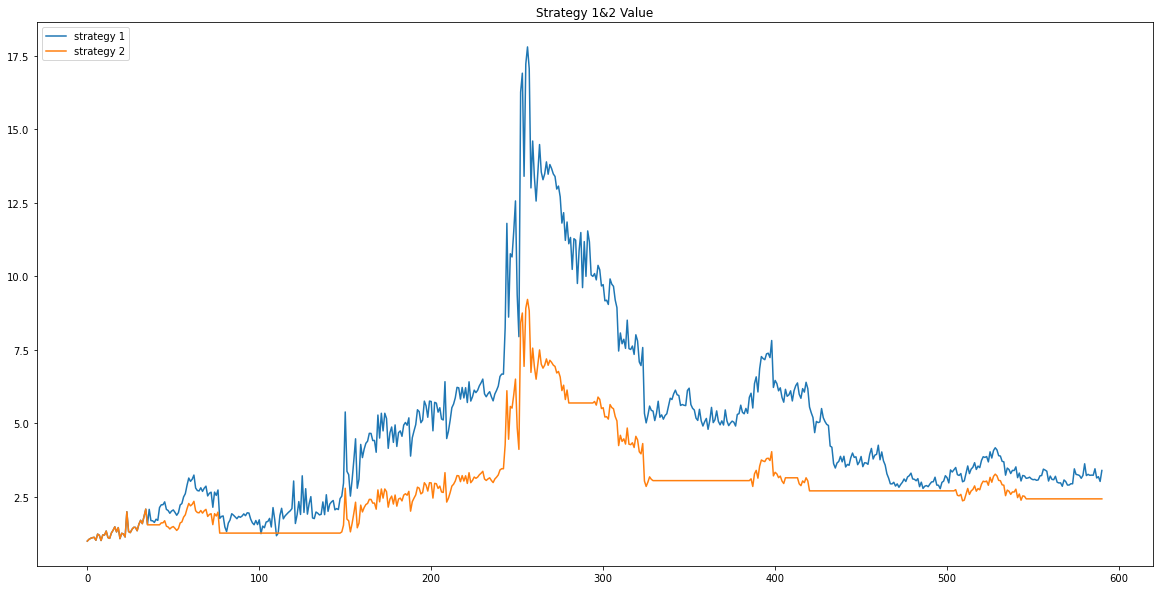

In [34]:
plt.figure(figsize=(20,10))
plt.plot(list(portfolio_value1.values()), label='strategy 1')
plt.plot(list(portfolio_value2.values()), label='strategy 2')
plt.legend(loc="upper left")
plt.title("Strategy 1&2 Value")
plt.show()

<div class="alert alert-block alert-success">
<strong><em>Evaluation and Comparison
</div>

In [35]:
from defi.evaluation import ann_estimated_sharpe_ratio, estimated_skewness, estimated_kurtosis, probabilistic_sharpe_ratio

In [36]:
df_porfolioValue = pd.DataFrame({'portfolioValue':portfolio_value1.values()},index=portfolio_value1.keys())
arPortfolioPrices = np.asarray(df_porfolioValue)
[rows, cols]= arPortfolioPrices.shape
returns_st1 = DefiReturnsComputing(arPortfolioPrices,rows,cols).reshape(1,-1)[0]

In [37]:
df_porfolioValue = pd.DataFrame({'portfolioValue':portfolio_value2.values()},index=portfolio_value1.keys())
arPortfolioPrices = np.asarray(df_porfolioValue)
[rows, cols]= arPortfolioPrices.shape
returns_st2 = DefiReturnsComputing(arPortfolioPrices,rows,cols).reshape(1,-1)[0]

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


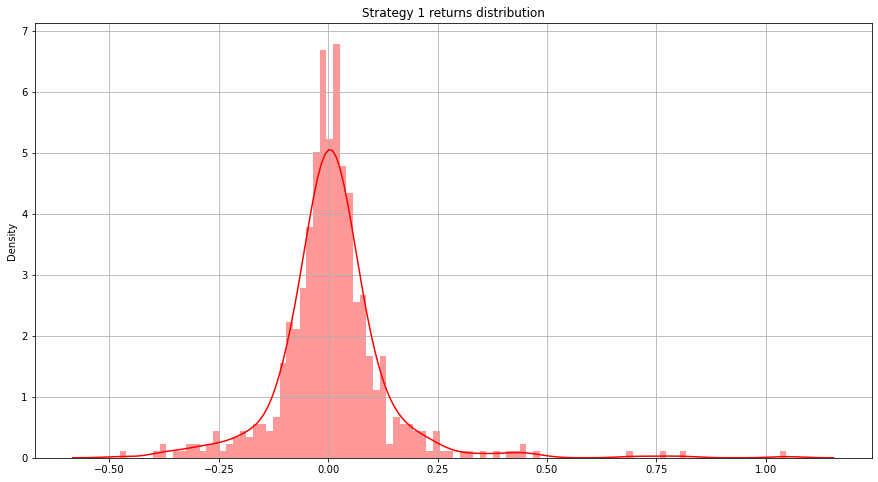

In [38]:
plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st1), hist=True, kde=True, color='red',  bins=100).set_title('Strategy 1 returns distribution')
plt.grid() 
plt.show()

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


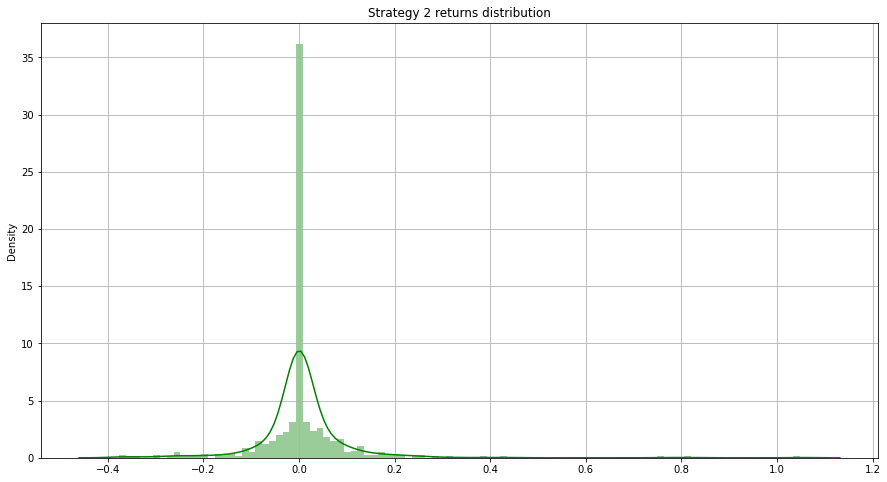

C:\Users\Mouad Bouaida\Anaconda3\envs\py39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


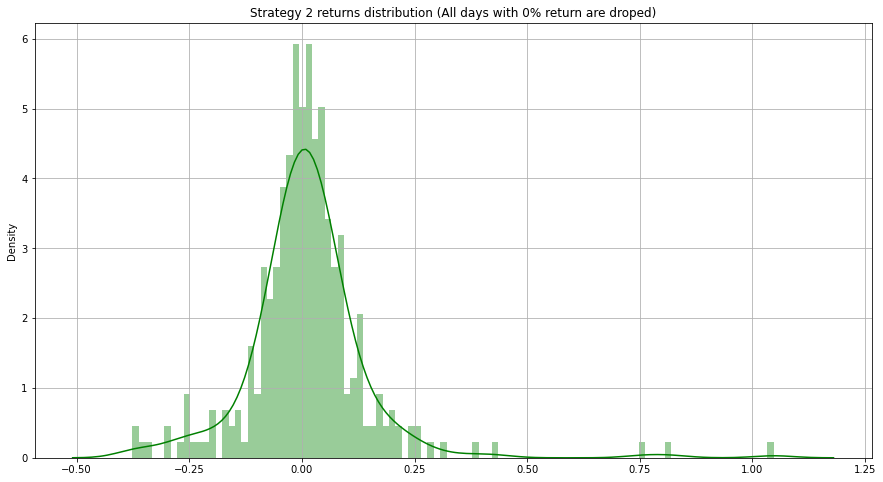

In [39]:
plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st2), hist=True, kde=True, color='green',  bins=100).set_title('Strategy 2 returns distribution')
plt.grid() 
plt.show()

plt.figure(figsize=(15,8))
sns.distplot(pd.Series(returns_st2[returns_st2!=0]), hist=True, kde=True, color='green',  bins=100).set_title('Strategy 2 returns distribution (All days with 0% return are droped)')
plt.grid() 
plt.show()

In [40]:
ann_sr_st1 = ann_estimated_sharpe_ratio(returns_st1)
ann_sr_st2 = ann_estimated_sharpe_ratio(returns_st2)
ann_sr_st2_0 = ann_estimated_sharpe_ratio(returns_st2[returns_st2!=0])

print('The annualized estimated sharpe ratio of strategy 1 : ', round(ann_sr_st1,3))
print('The annualized estimated sharpe ratio of strategy 2 : ', round(ann_sr_st2,3))
print('The annualized estimated sharpe ratio of strategy 2 (All 0% returns are droped) : ', round(ann_sr_st2_0,3))

The annualized estimated sharpe ratio of strategy 1 :  1.22
The annualized estimated sharpe ratio of strategy 2 :  0.965
The annualized estimated sharpe ratio of strategy 2 (All 0% returns are droped) :  1.337


In [41]:
skewness_st1 = estimated_skewness(returns_st1).values[0]
skewness_st2 = estimated_skewness(returns_st2).values[0]
skewness_st2_0 = estimated_skewness(returns_st2[returns_st2!=0]).values[0]

print('The estimated skewness of strategy 1 : ', round(skewness_st1,3))
print('The estimated skewness of strategy 2 : ', round(skewness_st2,3))
print('The estimated skewness of strategy 2 (All 0% returns are droped) : ', round(skewness_st2_0,3))

The estimated skewness of strategy 1 :  1.862
The estimated skewness of strategy 2 :  3.279
The estimated skewness of strategy 2 (All 0% returns are droped) :  2.262


In [42]:
kurtosis_st1 = estimated_kurtosis(returns_st1).values[0]
kurtosis_st2 = estimated_kurtosis(returns_st2).values[0]
kurtosis_st2_0 = estimated_kurtosis(returns_st2[returns_st2!=0]).values[0]

print('The estimated kurtosis of strategy 1 : ', round(kurtosis_st1,3))
print('The estimated kurtosis of strategy 2 : ', round(kurtosis_st2,3))
print('The estimated kurtosis of strategy 2 (All 0% returns are droped) : ', round(kurtosis_st2_0,3))

The estimated kurtosis of strategy 1 :  16.717
The estimated kurtosis of strategy 2 :  36.024
The estimated kurtosis of strategy 2 (All 0% returns are droped) :  18.562


In [43]:
psr_st1 = probabilistic_sharpe_ratio(returns_st1)
psr_st2 = probabilistic_sharpe_ratio(returns_st2)
psr_st2_0 = probabilistic_sharpe_ratio(returns_st2[returns_st2!=0])

print('PSR of strategy 1 :', round(psr_st1*100,2),'%')
print('PSR of strategy 2 :', round(psr_st2*100,2),'%')
print('PSR of strategy 2 (All 0% returns are droped) :', round(psr_st2_0*100,2),'%')

PSR of strategy 1 : 97.45 %
PSR of strategy 2 : 94.37 %
PSR of strategy 2 (All 0% returns are droped) : 94.29 %


<div class="alert alert-block alert-success">
<strong><em>Summary Table
</div>

In [44]:
pd.DataFrame({
    'Strategy 1':[str(round(np.mean(returns_st1*100),2))+'%',str(round(np.std(returns_st1*100),2))+'%',str(int(round((1+np.mean(returns_st1))**251-1,1)*100))+'%',round(ann_sr_st1,2),round(skewness_st1,2),round(kurtosis_st1,2),str(round(psr_st1*100,2))+'%'],
    'Strategy 2':[str(round(np.mean(returns_st2*100),2))+'%',str(round(np.std(returns_st2*100),2))+'%',str(int(round((1+np.mean(returns_st2))**251-1,1)*100))+'%',round(ann_sr_st2,2),round(skewness_st2,2),round(kurtosis_st2,2),str(round(psr_st2*100,2))+'%'],
    'Strategy 2 (0% returns filtred)':[str(round(np.mean(returns_st2[returns_st2!=0]*100),2))+'%',str(round(np.std(returns_st2[returns_st2!=0]*100),2))+'%',str(int(round((1+np.mean(returns_st2[returns_st2!=0]))**251-1,1)*100))+'%',round(ann_sr_st2_0,2),round(skewness_st2_0,2),round(kurtosis_st2_0,2),str(round(psr_st2_0*100,2))+'%']
},index=['Daily Excess Return','Daily Excess Return Std','Annualized Excess Return','Annualized Estimated Sharpe Ratio','Skewness','Kurtosis','Probabilistic Sharpe Ratio'])

,Strategy 1,Strategy 2,Strategy 2 (0% returns filtred)
Daily Excess Return,0.97%,0.6%,1.15%
Daily Excess Return Std,12.84%,10.05%,13.89%
Annualized Excess Return,1030%,350%,1670%
Annualized Estimated Sharpe Ratio,1.22,0.97,1.34
Skewness,1.86,3.28,2.26
Kurtosis,16.72,36.02,18.56
Probabilistic Sharpe Ratio,97.45%,94.37%,94.29%


## <font color='red'> Conclusion
<div class="alert alert-block alert-success">
<strong><em>
<p>The Table shows that all strategies delivred Sharpe ratios in a 0.97 to 1.34 range and a positive skewness. These solid Sharpe ratios were at least in part a compensation for the high volatility of Defi, taking ‘Momentum crash’ risk and the very eleveted tail risk (kurtosis much greater than 3).
    
<p>Even if we tried to diversify our portfolio by selecting Defi in different clusters. It seems that the Defi universe is very correlated and as a result of that all strategies suffer a sharp drawdown during market turning points.

<p>In addition to tail risk, there are other risks related to Momentum investing. For instance, Momentum can underperform during prolonged periods of range-bound price action and signals used to identify Momentum can also become ineffective.

<p>To reduce this risk we can for example use stop loss applied to our momentum strategies. Stop loss can in some cases improve the strategy’s risk adjusted performance. However, these improvements are not dramatic.So, there is no simple cost-less solution that would entirely eliminate momentum tail risk.

<p>By comparing these strategies we quickly realize that the first strategy is the best. It has the highest Sharpe ratio, positive skewness and the lowest kutrosis. Moreover, it has the highest Probabilistic Sharpe Ratio which means that strategy 1 has more chances that in the future its returns will have a sharpe ratio greater than 0.
</div>